## Data Preprocessing

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import os
import numpy as np
import sentencepiece as spm
import scienceplots
import pandas as pd
from rdkit import Chem

plt.rcParams.update({"text.usetex": True, "font.size": 14})
plt.style.use(["science", "no-latex"])

In [2]:
import torch, random

seed = 42
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)
random.seed(seed)

/home/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_path = os.path.join("Liu_Kheyer_Retrosynthesis_Data")
train_path = os.path.join(data_path, "train")
validation_path = os.path.join(data_path, "validation")
test_path = os.path.join(data_path, "test")
train_reactants_df = pd.read_csv(
    os.path.join(train_path, "train_targets.txt"), header=None
)
train_products_df = pd.read_csv(
    os.path.join(train_path, "train_sources.txt"), header=None
)

In [4]:
def process_dfs(react_df, prod_df):
    react_df_n = react_df.copy()
    prod_df_n = prod_df.copy()
    prod_df_n.rename(columns={0: "products"}, inplace=True)
    react_df_n.rename(columns={0: "reactants"}, inplace=True)
    prod_df_n["reaction_type"] = prod_df_n["products"].str.extract(r"(\<RX_.*\>)")
    prod_df_n["products"] = prod_df_n["products"].str.replace(
        r"(\<RX_.*\>)", "", regex=True
    )
    df = pd.concat([react_df_n, prod_df_n], axis=1)
    return df


def prepare_whole_reaction_padded(df):
    df["full_input_format_delimited"] = (
        "[BOS]" + df["reactants"] + ">>" + df["products"] + "[EOS]"
    )
    df["full_input_format_delimited"] = df["full_input_format_delimited"].str.replace(
        " ", ""
    )
    df["full_input_format"] = (
        df["reactants"].str.replace(" ", "")
        + ">>"
        + df["products"].str.replace(" ", "")
    )


df = process_dfs(train_reactants_df, train_products_df)
prepare_whole_reaction_padded(df)

params = Chem.rdChemReactions.ReactionFingerprintParams()
params.fpSize = 2048
df["rxn"] = df.apply(
    lambda x: Chem.rdChemReactions.ReactionFromSmarts(
        x["full_input_format"], useSmiles=True
    ),
    axis=1,
)
df["fingerprint"] = df.apply(
    lambda x: Chem.rdChemReactions.CreateDifferenceFingerprintForReaction(
        x["rxn"], params
    ),
    axis=1,
)

In [5]:
spt_1 = spm.SentencePieceTrainer.train(
    "--input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1"
)
sp = spm.SentencePieceProcessor()
sp.load("m.model")
print(sp.get_piece_size())

56


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Now we can tokenize the training data:

In [6]:
PAD_TOKEN = sp.encode_as_ids("[PAD]")[1]


def tokenize_and_pad(df, max_len=0):
    # choose to set the max_len based on a user entered value or the one derived from the data
    if max_len == 0:
        max_val = (
            df["input_ids"].str.len().sort_values(ascending=False).head(1).values[0]
        )
        print(max_val)
        return
    else:
        max_val = max_len
    # Create the encoded columns
    df["input_ids"] = (
        df["full_input_format_delimited"].apply(sp.encode_as_ids).apply(lambda x: x[1:])
    )
    df_new = df[df["input_ids"].apply(len) <= max_val].copy()
    print("removed ", df.shape[0] - df_new.shape[0], " samples")

    # calculate how much to pad for each case
    df_new["input_counts"] = max_val - df_new["input_ids"].str.len()

    # pad with the PAD_TOKEN
    df_new["input_ids"] = df_new.apply(
        lambda row: np.pad(
            row["input_ids"],
            (0, row["input_counts"]),
            mode="constant",
            constant_values=(0, PAD_TOKEN),
        ),
        axis=1,
    )

    return np.asarray(df_new["input_ids"].values.tolist()), max_val, df_new


train_inputs, train_input_len, df_with_max_200 = tokenize_and_pad(df, 200)
fingerprints = []
for i in df_with_max_200.index:
    array = np.zeros((0,), dtype=np.float64)
    Chem.DataStructs.ConvertToNumpyArray(df_with_max_200.loc[i, "fingerprint"], array)
    fingerprints.append(array)

df_with_max_200["input_ids"].str.len().sort_values(), len(fingerprints)

removed  474  samples


(0        200
 26676    200
 26677    200
 26678    200
 26679    200
         ... 
 13352    200
 13353    200
 13354    200
 13347    200
 40028    200
 Name: input_ids, Length: 39555, dtype: int64,
 39555)

Now let's create the pipeline for validation and test data:

In [7]:
def data_to_Ids_pipeline(reactants_df, products_df, max_len=0):
    dfa = process_dfs(reactants_df, products_df)
    prepare_whole_reaction_padded(dfa)
    inputs, input_len, dfa_new = tokenize_and_pad(dfa, max_len)
    return dfa_new, inputs, input_len


valid_products_df = pd.read_csv(
    os.path.join(validation_path, "valid_sources.txt"), header=None
)
valid_reactants_df = pd.read_csv(
    os.path.join(validation_path, "valid_targets.txt"), header=None
)

test_products_df = pd.read_csv(os.path.join(test_path, "test_sources.txt"), header=None)
test_reactants_df = pd.read_csv(
    os.path.join(test_path, "test_targets.txt"), header=None
)
valid_df, valid_inputs, valid_input_len = data_to_Ids_pipeline(
    valid_reactants_df, valid_products_df, max_len=200
)

test_df, test_inputs, test_input_len = data_to_Ids_pipeline(
    test_reactants_df, test_products_df, max_len=200
)
print("Shape of validation Ids inputs:", valid_inputs.shape)
print("Shape of Test Ids inputs:", test_inputs.shape)

removed  69  samples
removed  48  samples
Shape of validation Ids inputs: (4935, 200)
Shape of Test Ids inputs: (4956, 200)


## Data Visualization

In [35]:
import numpy as np
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition",
}

rxn2number = {
    "<RX_10>": 0,
    "<RX_1>": 1,
    "<RX_2>": 2,
    "<RX_3>": 3,
    "<RX_4>": 4,
    "<RX_5>": 5,
    "<RX_6>": 6,
    "<RX_7>": 7,
    "<RX_8>": 8,
    "<RX_9>": 9,
}


def pca_umap_reduction(data, pca_components, plot_variance=False, seed=42):
    if len(data) == 1:
        data = data[0]
        # Step 1: Perform PCA to reduce to pca_components dimensions
        pca = PCA(n_components=pca_components)
        pca.fit(data)
        pca_result = pca.transform(data)

        # Optionally plot the explained variance
        if plot_variance:
            plt.figure(figsize=(10, 6))
            plt.plot(
                np.arange(1, pca_components + 1),
                pca.explained_variance_ratio_,
                marker="o",
                linestyle="--",
            )
            plt.title("Explained Variance by PCA Components")
            plt.xlabel("PCA Component")
            plt.ylabel("Explained Variance Ratio")
            plt.xticks(np.arange(1, pca_components + 1))
            plt.grid(True)
            plt.show()

        # Step 2: Perform UMAP to reduce the dimensions further to 2D
        if pca_components > 2:
            umap_reducer = umap.UMAP(n_components=2, random_state=seed)
            umap_reducer.fit(pca_result)
            reduced_data = umap_reducer.transform(pca_result)

            return reduced_data
        else:
            return pca_result
    else:
        # Step 1: Perform PCA to reduce to pca_components dimensions
        pca = PCA(n_components=pca_components)
        pca.fit(data[0])
        pca_result_1 = pca.transform(data[0])
        pca_result_2 = pca.transform(data[1])
        pca_result_3 = pca.transform(data[2])

        # Optionally plot the explained variance
        if plot_variance:
            plt.figure(figsize=(10, 6))
            plt.plot(
                np.arange(1, pca_components + 1),
                pca.explained_variance_ratio_,
                marker="o",
                linestyle="--",
            )
            plt.title("Explained Variance by PCA Components")
            plt.xlabel("PCA Component")
            plt.ylabel("Explained Variance Ratio")
            plt.xticks(np.arange(1, pca_components + 1))
            plt.grid(True)
            plt.show()

        # Step 2: Perform UMAP to reduce the dimensions further to 2D
        if pca_components > 2:
            umap_reducer = umap.UMAP(n_components=2)
            umap_reducer.fit(pca_result_1)
            reduced_data_1 = umap_reducer.transform(pca_result_1)
            reduced_data_2 = umap_reducer.transform(pca_result_2)
            reduced_data_3 = umap_reducer.transform(pca_result_3)

            return reduced_data_1, reduced_data_2, reduced_data_3
        else:
            return pca_result_1, pca_result_2, pca_result_3

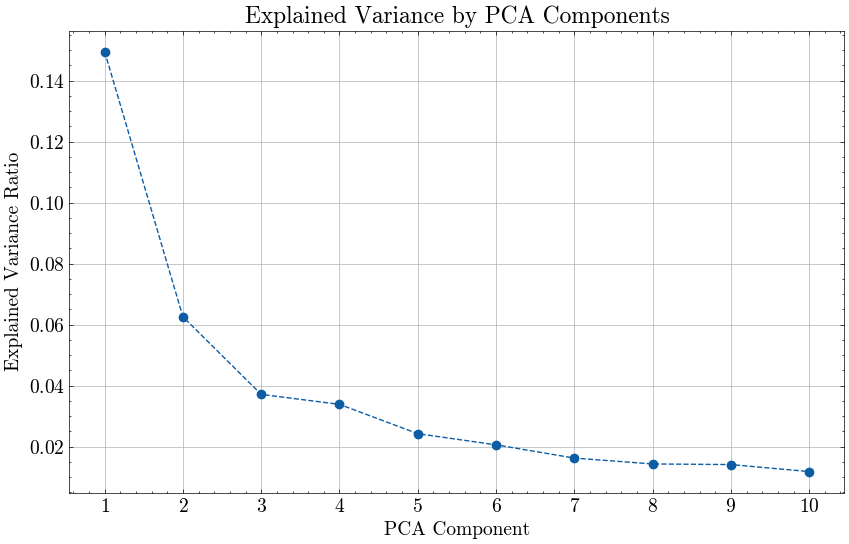

In [ ]:
fingerprints_umap2 = pca_umap_reduction(
    [fingerprints], pca_components=10, plot_variance=True
)

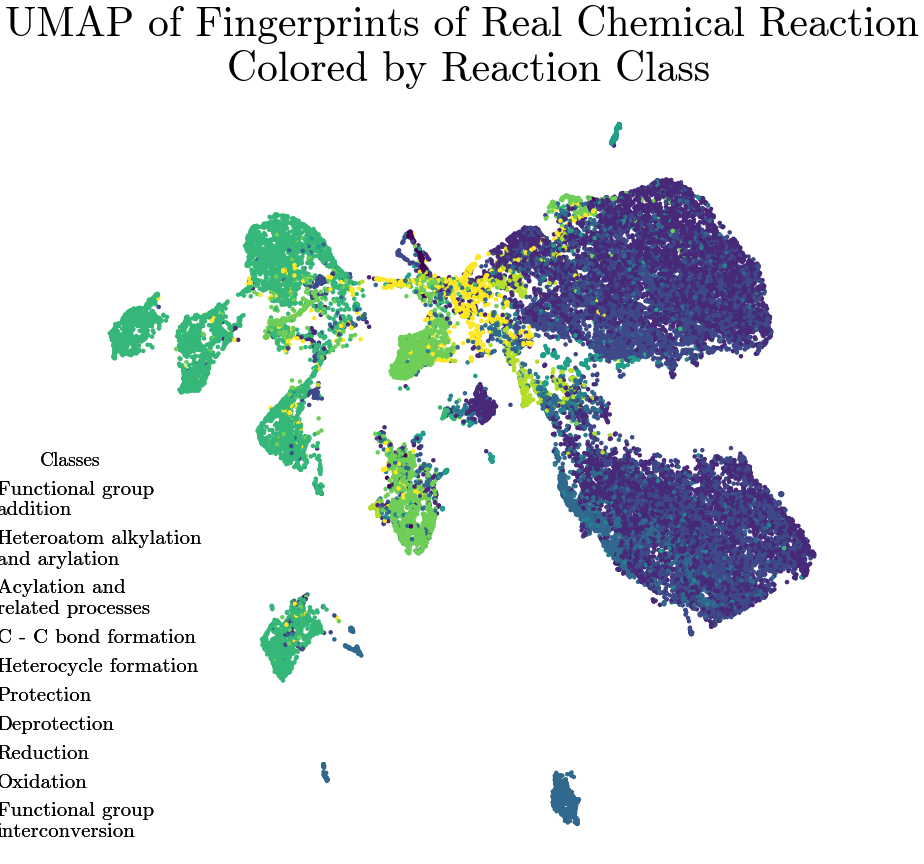

In [ ]:
reaction_type_encoded = df_with_max_200["reaction_type"].apply(lambda x: rxn2number[x])

# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap2[:, 0],
    fingerprints_umap2[:, 1],
    s=5,
    c=reaction_type_encoded,
    cmap="viridis",
)

legend1 = ax.legend(
    *scatter.legend_elements(),
    loc="lower left",
    bbox_to_anchor=(-0.2, 0),
    title="Classes",
    fontsize=15,
)
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Real Chemical Reaction\n Colored by Reaction Class",
    fontsize=30,
)

# plt.show()
plt.savefig("results/new/umap_original_colored_by_rxns.pdf")

### Visualizing UMAP of VAE vs Original

In [8]:
import torch
import random
import json

with open("configs/VAE_vanilla_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()

# fix seeds
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [9]:
from eval import Evaluator
from generate import VAEGenerator
from utils import predict_rxn_type

vae_generator = VAEGenerator(config)
evaluator = Evaluator(config)
# "model_weights/synthesizer/reproduced/v4/vae_epoch76_kl1_warm_up10_aggressiveFalse_loss49.0124.pt"
vae_generator.generate_samples(seed=1000)
evaluator.load_generated_dataset(config["gene_path"])

evaluator.process_results(use_filters=False)
evaluator.rxn_pred = predict_rxn_type(
    evaluator.rxn_classifier, evaluator.gen_fingerprints
)
gen_fingerprints_1 = evaluator.gen_fingerprints
rxn_pred_1 = evaluator.rxn_pred

evaluator.process_results(use_filters=True)
evaluator.rxn_pred = predict_rxn_type(
    evaluator.rxn_classifier, evaluator.gen_fingerprints
)
gen_fingerprints_2 = evaluator.gen_fingerprints
rxn_pred_2 = evaluator.rxn_pred

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

In [104]:
len(gen_fingerprints_1), len(gen_fingerprints_2)

(33977, 12521)

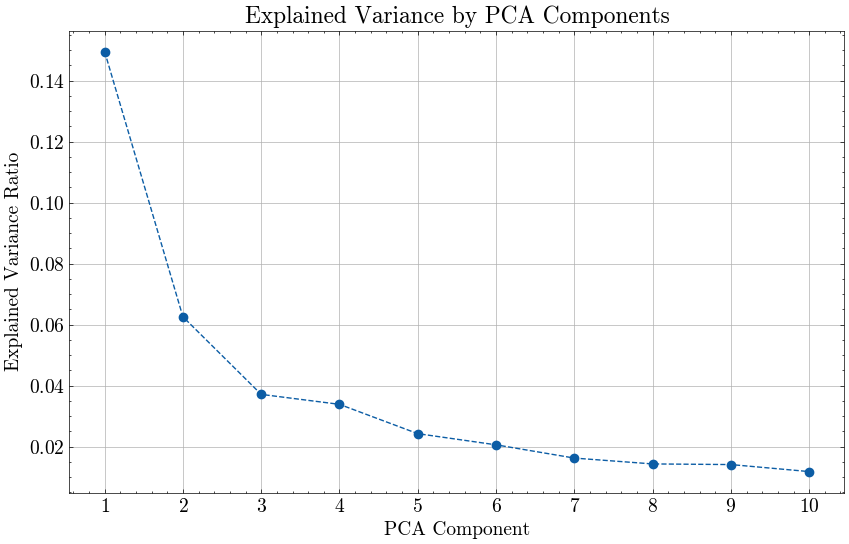

In [ ]:
fingerprints_umap2, fingerprints_umap21, fingerprints_umap22 = pca_umap_reduction(
    [fingerprints, gen_fingerprints_1, gen_fingerprints_2],
    pca_components=10,
    plot_variance=True,
)

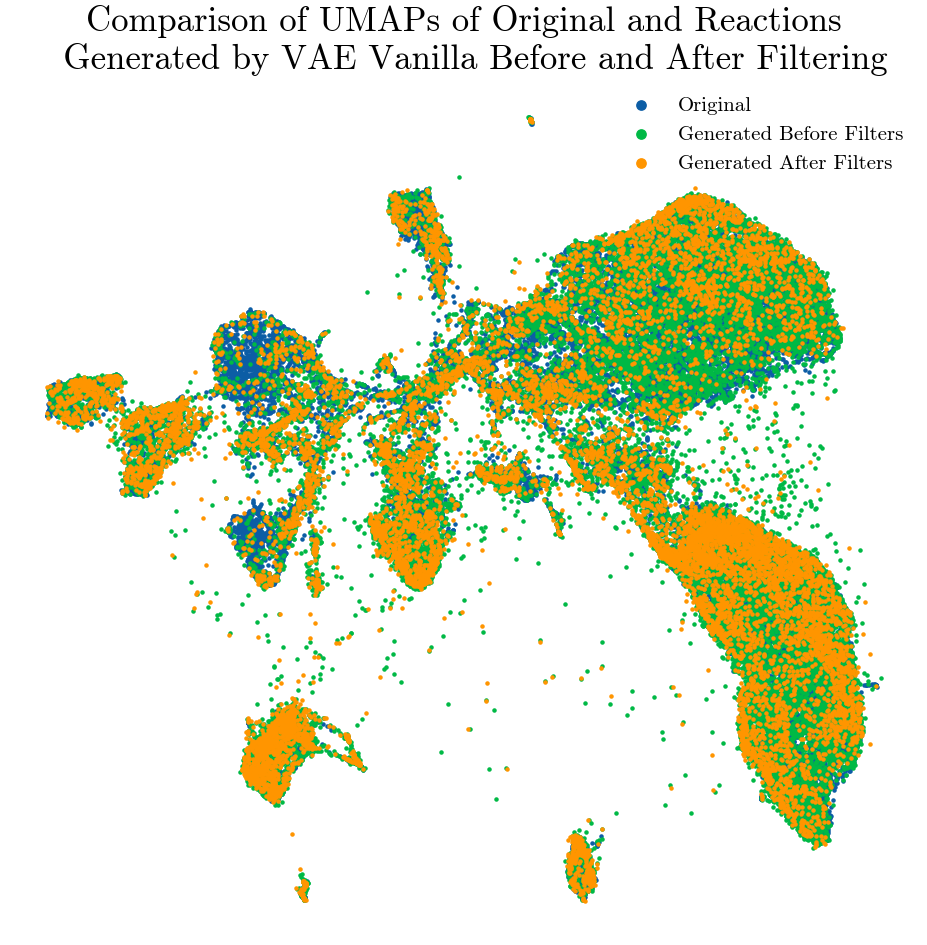

In [ ]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap2[:, 0], fingerprints_umap2[:, 1], s=5, label="Original"
)
scatter = ax.scatter(
    fingerprints_umap21[:, 0],
    fingerprints_umap21[:, 1],
    s=5,
    label="Generated Before Filters",
)
scatter = ax.scatter(
    fingerprints_umap22[:, 0],
    fingerprints_umap22[:, 1],
    s=5,
    label="Generated After Filters",
)


plt.title(
    "Comparison of UMAPs of Original and Reactions\n  Generated by VAE Vanilla Before and After Filtering",
    fontsize=25,
)

plt.tight_layout()
plt.legend(fontsize=15, markerscale=3)
ax.set_axis_off()
# plt.show()
plt.savefig("results/new/rxn_vae_umap_before_after.pdf", bbox_inches="tight")

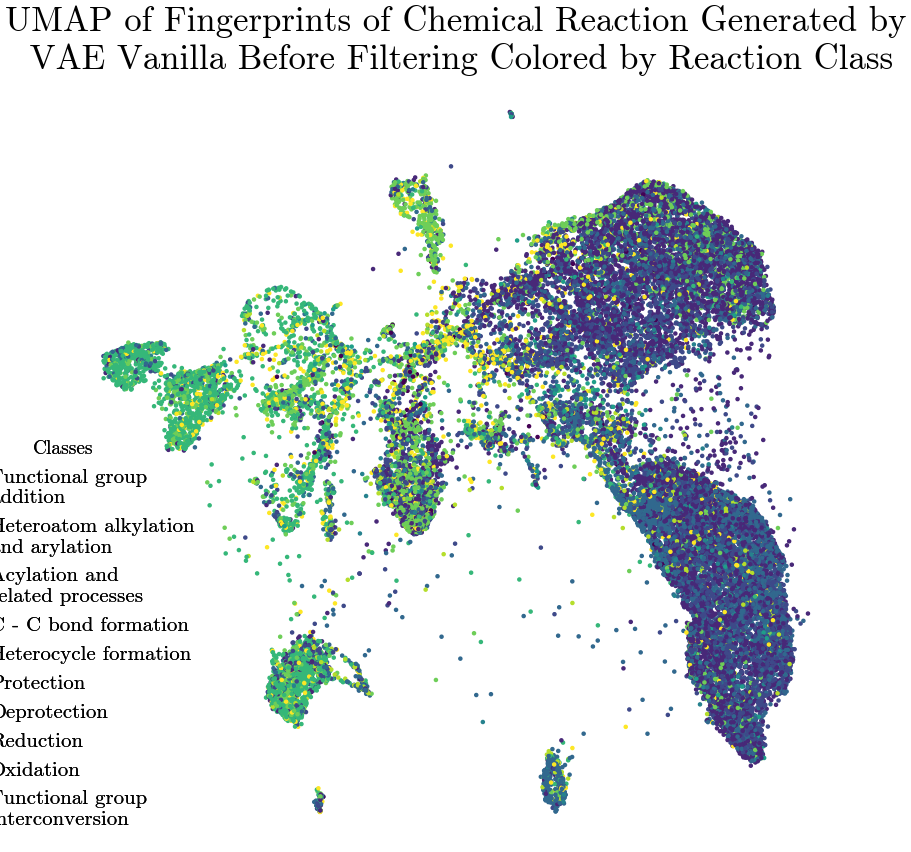

In [ ]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap21[:, 0],
    fingerprints_umap21[:, 1],
    s=5,
    c=rxn_pred_1,
    cmap="viridis",
)

legend1 = ax.legend(
    *scatter.legend_elements(),
    loc="lower left",
    bbox_to_anchor=(-0.2, 0),
    title="Classes",
    fontsize=15,
)
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Chemical Reaction Generated by\n VAE Vanilla Before Filtering Colored by Reaction Class",
    fontsize=25,
)

plt.savefig("results/new/umap_vae_generated_before_filtering_colored_by_rxns.pdf")

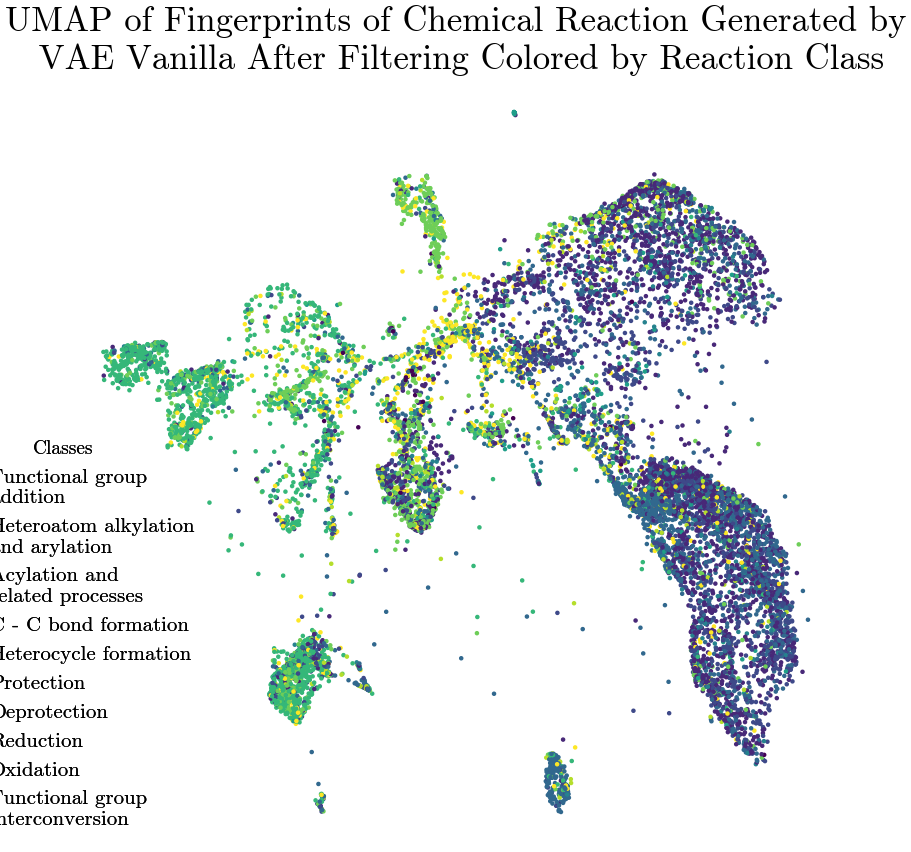

In [ ]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap22[:, 0],
    fingerprints_umap22[:, 1],
    s=5,
    c=rxn_pred_2,
    cmap="viridis",
)

legend1 = ax.legend(
    *scatter.legend_elements(),
    loc="lower left",
    bbox_to_anchor=(-0.2, 0),
    title="Classes",
    fontsize=15,
)
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Chemical Reaction Generated by\n VAE Vanilla After Filtering Colored by Reaction Class",
    fontsize=25,
)

plt.savefig("results/new/umap_vae_generated_after_filtering_colored_by_rxns.pdf")

In [10]:
vae_fingerprints = gen_fingerprints_2.copy()

In [11]:
vae_rxn_pred_1 = rxn_pred_1.copy()
vae_rxn_pred_2 = rxn_pred_2.copy()

### Visualizing UMAP of LSTM L=1 vs Original

In [114]:
import torch
import random
import json

with open("configs/LSTM_1layer_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()

# fix seeds
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [115]:
from eval import Evaluator
from generate import LSTMLMGenerator
from utils import predict_rxn_type

vae_generator = LSTMLMGenerator(config)
evaluator = Evaluator(config)
vae_generator.generate_samples(seed=1000)
evaluator.load_generated_dataset(config["gene_path"])

evaluator.process_results(use_filters=False)
evaluator.rxn_pred = predict_rxn_type(
    evaluator.rxn_classifier, evaluator.gen_fingerprints
)
gen_fingerprints_1 = evaluator.gen_fingerprints
rxn_pred_1 = evaluator.rxn_pred

evaluator.process_results(use_filters=True)
evaluator.rxn_pred = predict_rxn_type(
    evaluator.rxn_classifier, evaluator.gen_fingerprints
)
gen_fingerprints_2 = evaluator.gen_fingerprints
rxn_pred_2 = evaluator.rxn_pred

/home/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_

In [113]:
len(gen_fingerprints_1), len(gen_fingerprints_2)

(24788, 6257)

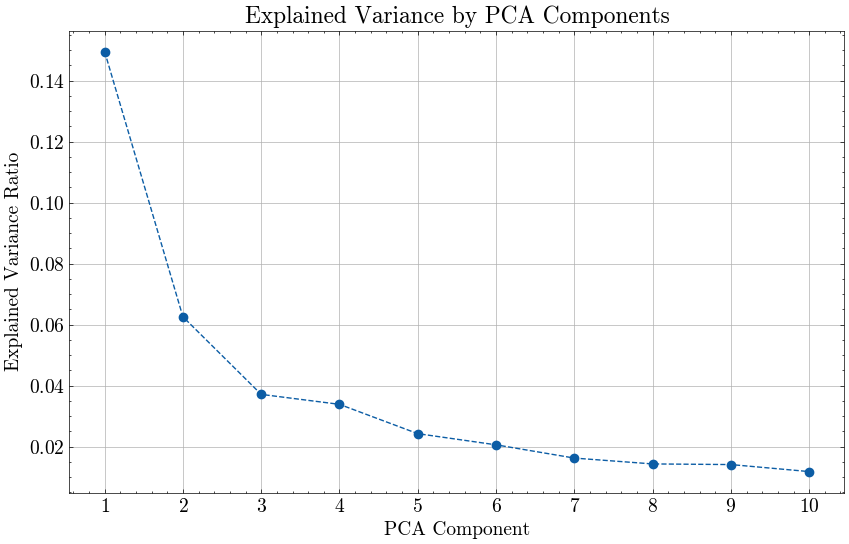

In [ ]:
fingerprints_umap2, fingerprints_umap21, fingerprints_umap22 = pca_umap_reduction(
    [fingerprints, gen_fingerprints_1, gen_fingerprints_2],
    pca_components=10,
    plot_variance=True,
)

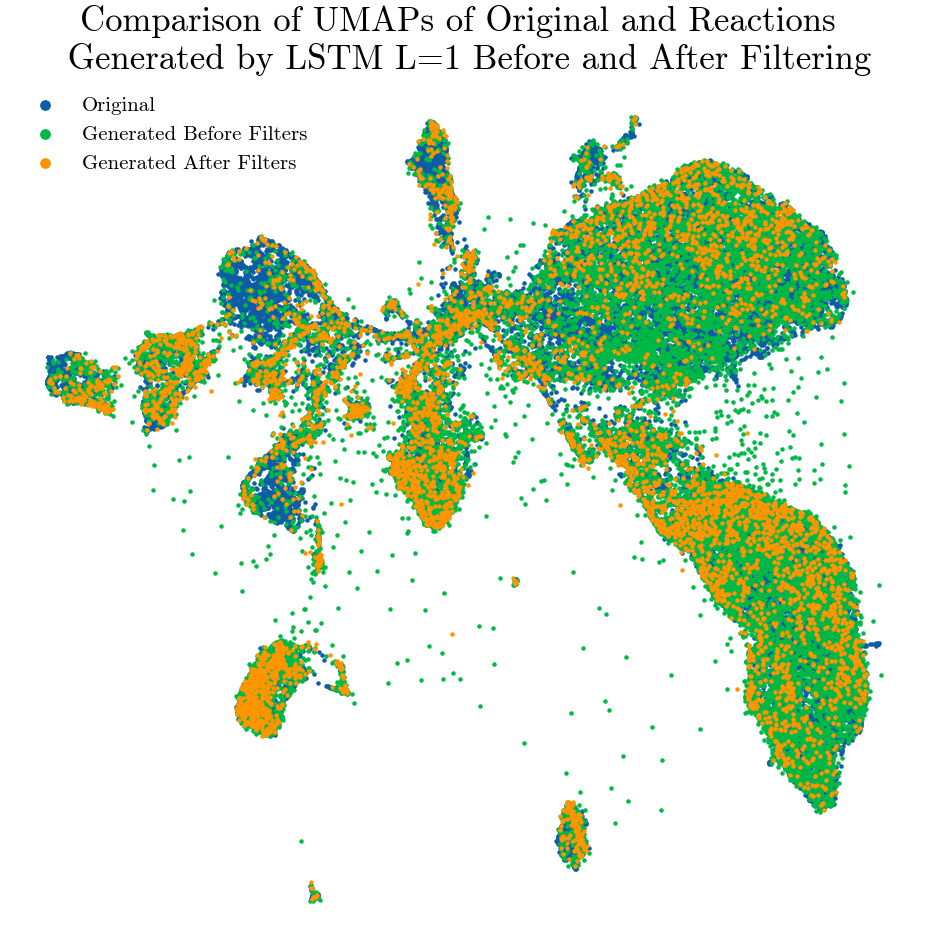

In [ ]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap2[:, 0], fingerprints_umap2[:, 1], s=5, label="Original"
)
scatter = ax.scatter(
    fingerprints_umap21[:, 0],
    fingerprints_umap21[:, 1],
    s=5,
    label="Generated Before Filters",
)
scatter = ax.scatter(
    fingerprints_umap22[:, 0],
    fingerprints_umap22[:, 1],
    s=5,
    label="Generated After Filters",
)


plt.title(
    "Comparison of UMAPs of Original and Reactions \n Generated by LSTM L=1 Before and After Filtering",
    fontsize=25,
)

plt.tight_layout()
plt.legend(fontsize=15, markerscale=3)
ax.set_axis_off()
# plt.show()
plt.savefig("results/new/rxn_lstm_umap_before_after.pdf", bbox_inches="tight")

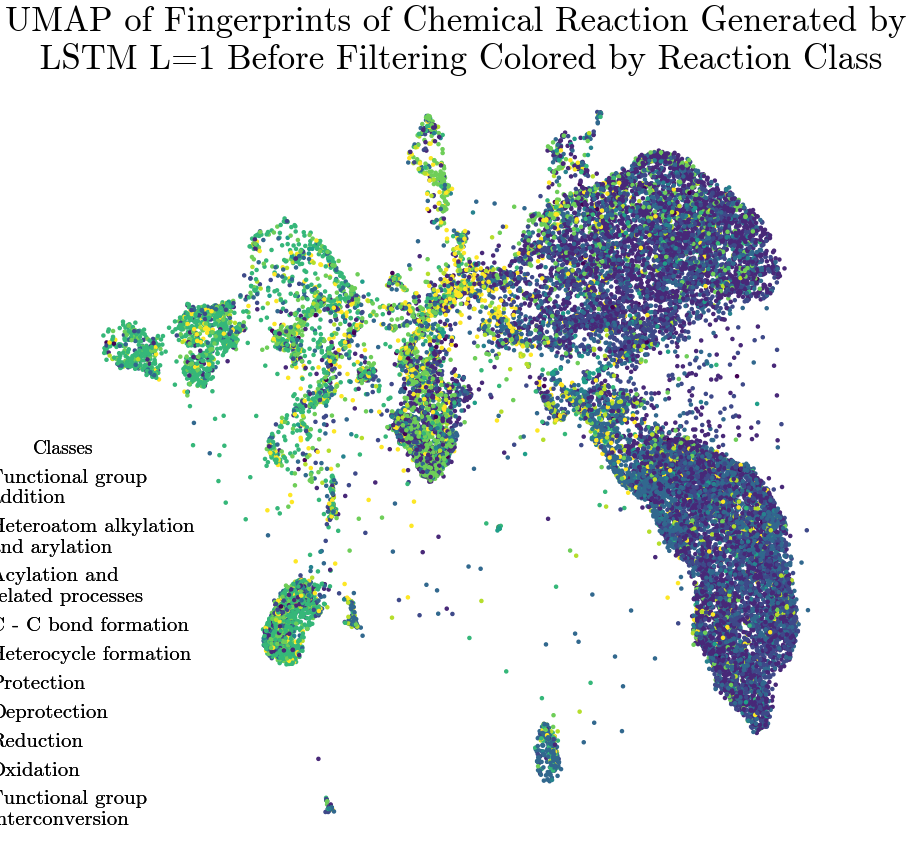

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap21[:, 0],
    fingerprints_umap21[:, 1],
    s=5,
    c=rxn_pred_1,
    cmap="viridis",
)

legend1 = ax.legend(
    *scatter.legend_elements(),
    loc="lower left",
    bbox_to_anchor=(-0.2, 0),
    title="Classes",
    fontsize=15,
)
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Chemical Reaction Generated by\n LSTM L=1 Before Filtering Colored by Reaction Class",
    fontsize=25,
)

plt.savefig("results/new/umap_lstm_generated_before_filtering_colored_by_rxns.pdf")


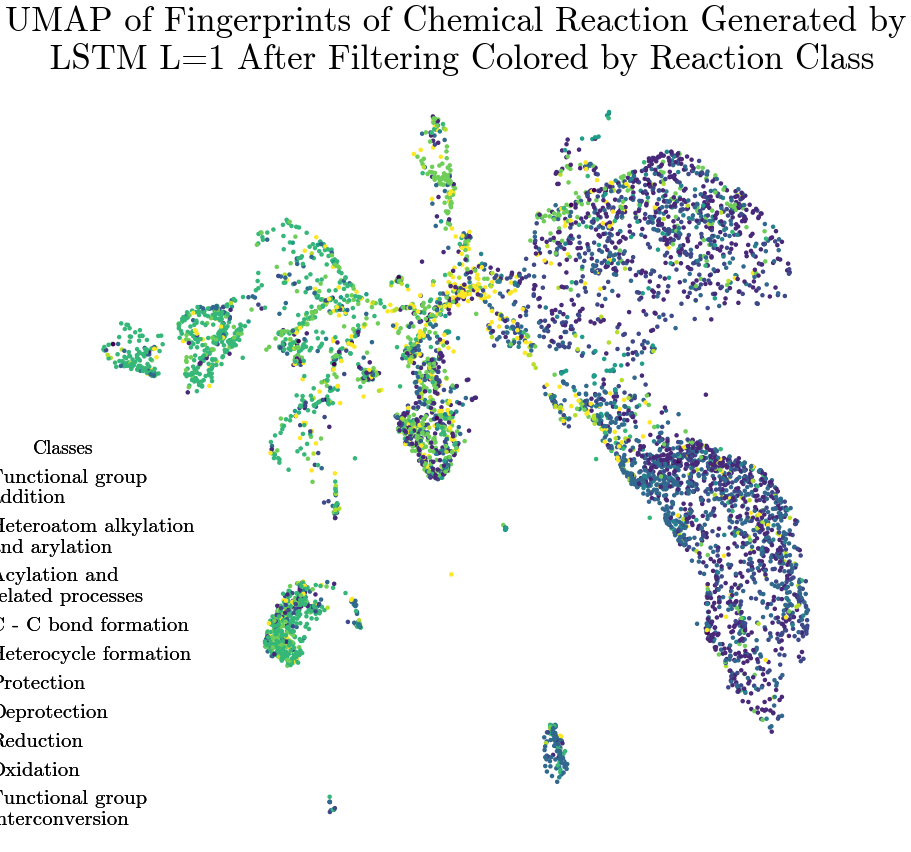

In [ ]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap22[:, 0],
    fingerprints_umap22[:, 1],
    s=5,
    c=rxn_pred_2,
    cmap="viridis",
)

legend1 = ax.legend(
    *scatter.legend_elements(),
    loc="lower left",
    bbox_to_anchor=(-0.2, 0),
    title="Classes",
    fontsize=15,
)
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Chemical Reaction Generated by\n LSTM L=1 After Filtering Colored by Reaction Class",
    fontsize=25,
)

plt.savefig("results/new/umap_lstm_generated_after_filtering_colored_by_rxns.pdf")


In [32]:
lstm_fingerprints = gen_fingerprints_2.copy()

In [116]:
lstm_rxn_pred2_counts = (
    pd.Series(rxn_pred_2).apply(lambda x: reaction_data[x]).value_counts(normalize=True)
)

In [117]:
lstm_rxn_pred2_counts

Heteroatom alkylation\nand arylation    0.212242
C - C bond formation                    0.201694
Deprotection                            0.177881
Reduction                               0.130734
Acylation and\nrelated processes        0.117309
Functional group\ninterconversion       0.079431
Heterocycle formation                   0.030366
Oxidation                               0.029567
Protection                              0.016781
Functional group\naddition              0.003996
Name: proportion, dtype: float64

### Comparing LSTM L=1 and VAE Vanilla to Original Dataset

In [ ]:
len(lstm_fingerprints), len(vae_fingerprints)

(6257, 12521)

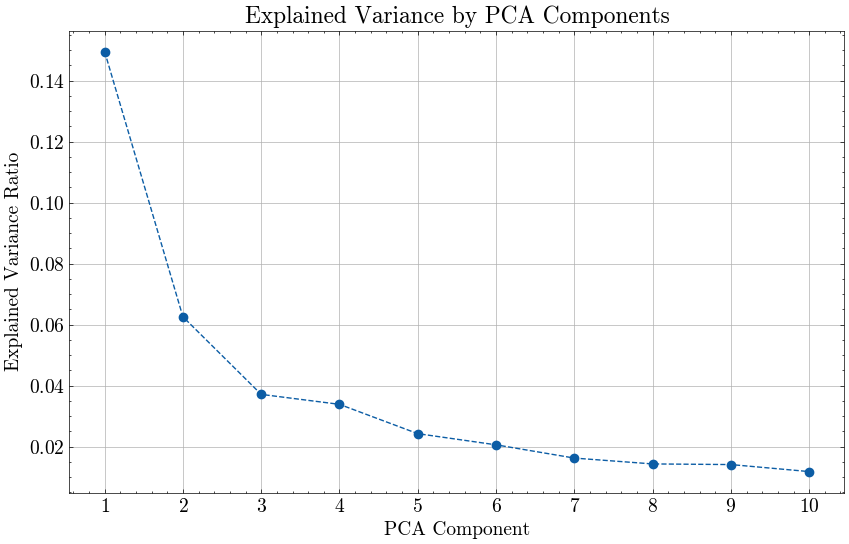

In [36]:
fingerprints_umap2, fingerprints_umap21, fingerprints_umap22 = pca_umap_reduction(
    [fingerprints, lstm_fingerprints, vae_fingerprints],
    pca_components=10,
    plot_variance=True,
    seed=42,
)

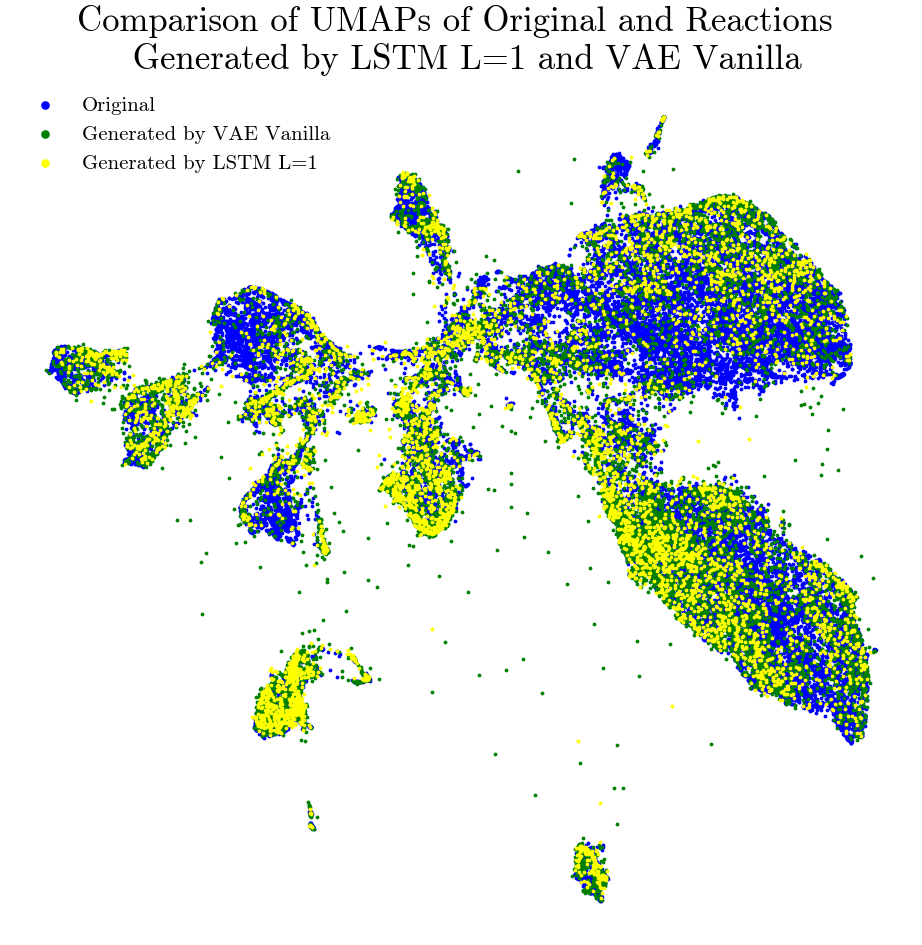

In [ ]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap2[:, 0], fingerprints_umap2[:, 1], s=3, label="Original", c="blue"
)
scatter = ax.scatter(
    fingerprints_umap22[:, 0],
    fingerprints_umap22[:, 1],
    s=3,
    label="Generated by VAE Vanilla",
    c="green",
)
scatter = ax.scatter(
    fingerprints_umap21[:, 0],
    fingerprints_umap21[:, 1],
    s=3,
    label="Generated by LSTM L=1",
    c="yellow",
)

plt.title(
    "Comparison of UMAPs of Original and Reactions \n Generated by LSTM L=1 and VAE Vanilla",
    fontsize=25,
)

plt.tight_layout()
plt.legend(fontsize=15, markerscale=3)
ax.set_axis_off()
# plt.show()
plt.savefig("results/new/rxn_lstm_vae_original_umap.pdf", bbox_inches="tight")

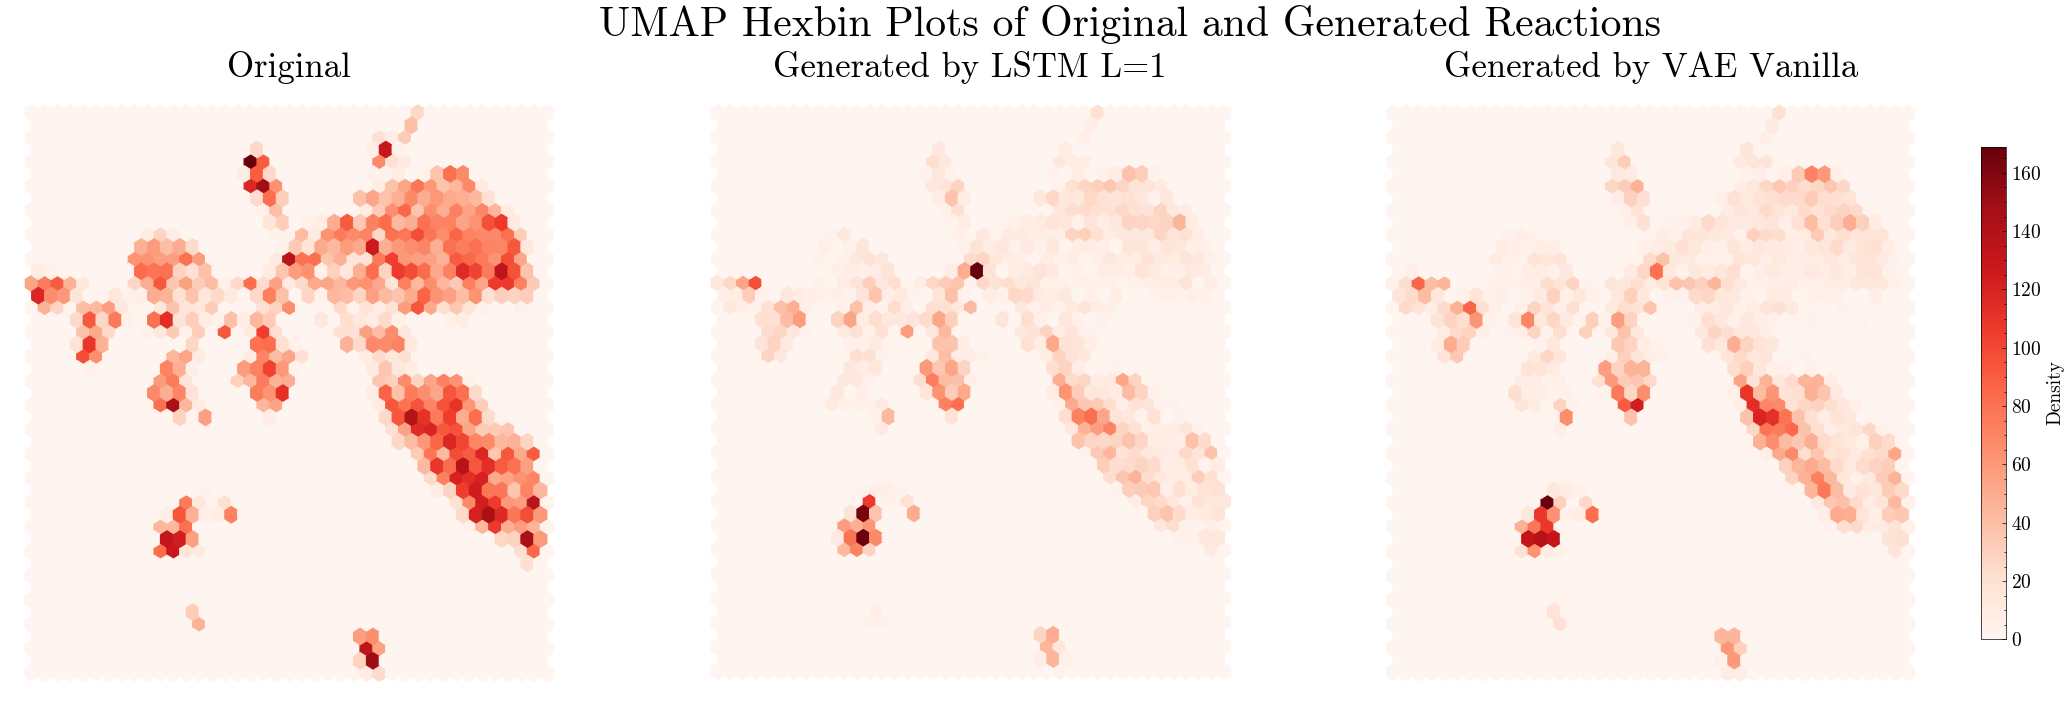

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharex=True, sharey=True)

# Dataset titles and color maps
datasets = [
    (fingerprints_umap2, "Original", "Reds"),
    (fingerprints_umap21, "Generated by LSTM L=1", "Reds"),
    (fingerprints_umap22, "Generated by VAE Vanilla", "Reds"),
]

# Plot each dataset in its own subplot
for ax, (data, title, cmap) in zip(axes, datasets):
    hb = ax.hexbin(data[:, 0], data[:, 1], gridsize=40, cmap=cmap, alpha=1)
    ax.set_title(title, fontsize=25)
    ax.set_axis_off()

# Add a single colorbar for all subplots
cbar = fig.colorbar(
    hb, ax=axes, orientation="vertical", shrink=0.8, pad=0.02, label="Density"
)

# Set the overall title and layout
plt.suptitle("UMAP Hexbin Plots of Original and Generated Reactions", fontsize=30)

# plt.show()
plt.savefig("results/new/umap_hexbin_subplots.pdf")


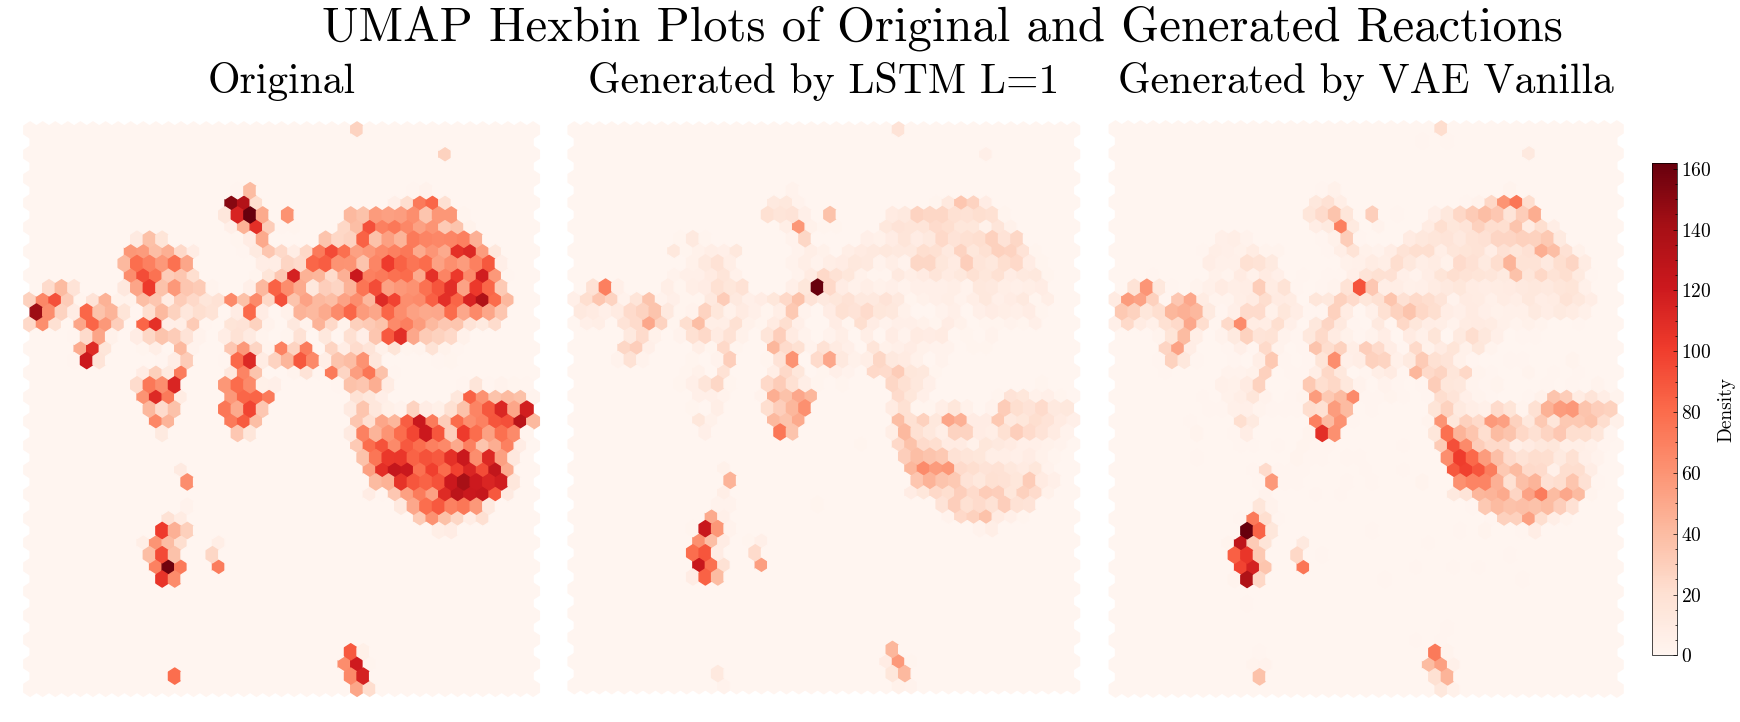

In [106]:
import matplotlib.pyplot as plt

# Set up the figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 8), sharex=True, sharey=True)

# Dataset titles and color maps
datasets = [
    (fingerprints_umap2, "Original", "Reds"),
    (fingerprints_umap21, "Generated by LSTM L=1", "Reds"),
    (fingerprints_umap22, "Generated by VAE Vanilla", "Reds"),
]

# Plot each dataset in its own subplot
for ax, (data, title, cmap) in zip(axes, datasets):
    hb = ax.hexbin(data[:, 0], data[:, 1], gridsize=40, cmap=cmap, alpha=1)
    ax.set_title(title, fontsize=30)
    ax.set_axis_off()

# Add a single colorbar for all subplots
cbar = fig.colorbar(
    hb, ax=axes, orientation="vertical", shrink=0.8, pad=0.1, label="Density"
)

# Set the overall title and layout
plt.suptitle("UMAP Hexbin Plots of Original and Generated Reactions", fontsize=35, y=1)

# Adjust spacing between subplots and the colorbar
plt.subplots_adjust(wspace=-0.02, right=0.78)

plt.savefig("results/new/umap_hexbin_subplots2.jpeg", dpi=500)


### Comparing Reaction Distributions Across Training Dataset and VAE Models

In [12]:
reaction_data = {
    "<RX_1>": "Heteroatom alkylation\nand arylation",
    "<RX_2>": "Acylation and\nrelated processes",
    "<RX_3>": "C - C bond formation",
    "<RX_4>": "Heterocycle formation",
    "<RX_5>": "Protection",
    "<RX_6>": "Deprotection",
    "<RX_7>": "Reduction",
    "<RX_8>": "Oxidation",
    "<RX_9>": "Functional group\ninterconversion",
    "<RX_10>": "Functional group\naddition",
}
reaction_counts = (
    df_with_max_200["reaction_type"]
    .apply(lambda x: reaction_data[x])
    .value_counts(normalize=True)
)
reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition",
}
vae_rxn_pred1_counts = (
    pd.Series(vae_rxn_pred_1)
    .apply(lambda x: reaction_data[x])
    .value_counts(normalize=True)
)
vae_rxn_pred2_counts = (
    pd.Series(vae_rxn_pred_2)
    .apply(lambda x: reaction_data[x])
    .value_counts(normalize=True)
)

pred_1_counts = (
    pd.Series(vae_rxn_pred_1).apply(lambda x: reaction_data[x]).value_counts()
)
pred_2_counts = (
    pd.Series(vae_rxn_pred_2).apply(lambda x: reaction_data[x]).value_counts()
)
relative_difference = (pred_2_counts - pred_1_counts) / pred_1_counts
combined = pd.concat(
    [reaction_counts, vae_rxn_pred1_counts, vae_rxn_pred2_counts, relative_difference],
    axis=1,
)
combined.columns = ["Original", "Before", "After", "Delta"]
combined["Original-Before"] = abs(combined["Original"] - combined["Before"])
combined["Original-After"] = abs(combined["Original"] - combined["After"])
combined["ratio"] = combined["Original-Before"] / combined["Original-After"]
combined

Original    Before     After     Delta  \
Heteroatom alkylation\nand arylation  0.303501  0.271478  0.224343 -0.695468   
Acylation and\nrelated processes      0.236329  0.180799  0.147352 -0.699658   
Deprotection                          0.166578  0.105601  0.161728 -0.435619   
C - C bond formation                  0.112375  0.219678  0.212363 -0.643757   
Reduction                             0.092201  0.109839  0.123712 -0.584941   
Functional group\ninterconversion     0.036835  0.048003  0.064212 -0.507051   
Heterocycle formation                 0.018152  0.024105  0.021883 -0.665446   
Oxidation                             0.016332  0.024664  0.025637 -0.616945   
Protection                            0.013121  0.012361  0.015973 -0.523810   
Functional group\naddition            0.004576  0.003473  0.002795 -0.703390   

                                      Original-Before  Original-After  \
Heteroatom alkylation\nand arylation         0.032024        0.079158   
Acylation and\nrelated processes             0.055530        0.088977   
Deprotection                                 0.060977        0.004850   
C - C bond formation                         0.107303        0.099988   
Reduction                                    0.017638        0.031511   
Functional group\ninterconversion            0.011168        0.027377   
Heterocycle formation                        0.005953        0.003731   
Oxidation                                    0.008332        0.009305   
Protection                                   0.000760        0.002852   
Functional group\naddition                   0.001103        0.001781   

                                          ratio  
Heteroatom alkylation\nand arylation   0.404552  
Acylation and\nrelated processes       0.624100  
Deprotection                          12.572942  
C - C bond formation                   1.073157  
Reduction                              0.559742  
Functional group\ninterconversion      0.407939  
Heterocycle formation                  1.595317  
Oxidation                              0.895415  
Protection                             0.266345  
Functional group\naddition             0.619436

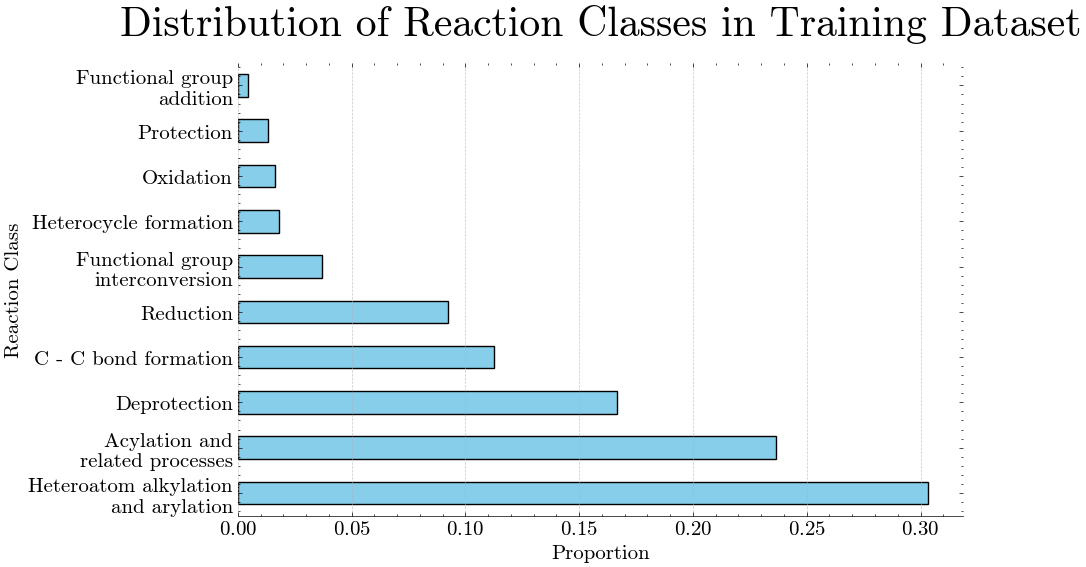

In [ ]:
reaction_data = {
    "<RX_1>": "Heteroatom alkylation\nand arylation",
    "<RX_2>": "Acylation and\nrelated processes",
    "<RX_3>": "C - C bond formation",
    "<RX_4>": "Heterocycle formation",
    "<RX_5>": "Protection",
    "<RX_6>": "Deprotection",
    "<RX_7>": "Reduction",
    "<RX_8>": "Oxidation",
    "<RX_9>": "Functional group\ninterconversion",
    "<RX_10>": "Functional group\naddition",
}

# Convert reaction codes to descriptions and calculate the frequency
reaction_counts = (
    df_with_max_200["reaction_type"]
    .apply(lambda x: reaction_data[x])
    .value_counts(normalize=True)
)

# Plotting
plt.figure(figsize=(10, 6))
reaction_counts.plot(kind="barh", color="skyblue", edgecolor="black")

# Beautify the plot
plt.title(
    "Distribution of Reaction Classes in Training Dataset",
    fontsize=30,
    weight="bold",
    pad=20,
)
plt.xlabel("Proportion", fontsize=15, weight="bold")
plt.ylabel("Reaction Class", fontsize=15, weight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Removing the spines for a cleaner look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/rxn_bar.pdf", bbox_inches="tight", dpi=500)

In [ ]:
valid_df = evaluator.df[evaluator.df["isValid"]].copy()
valid_df["rxn_type"] = rxn_pred_1
valid_df.shape

(32470, 13)

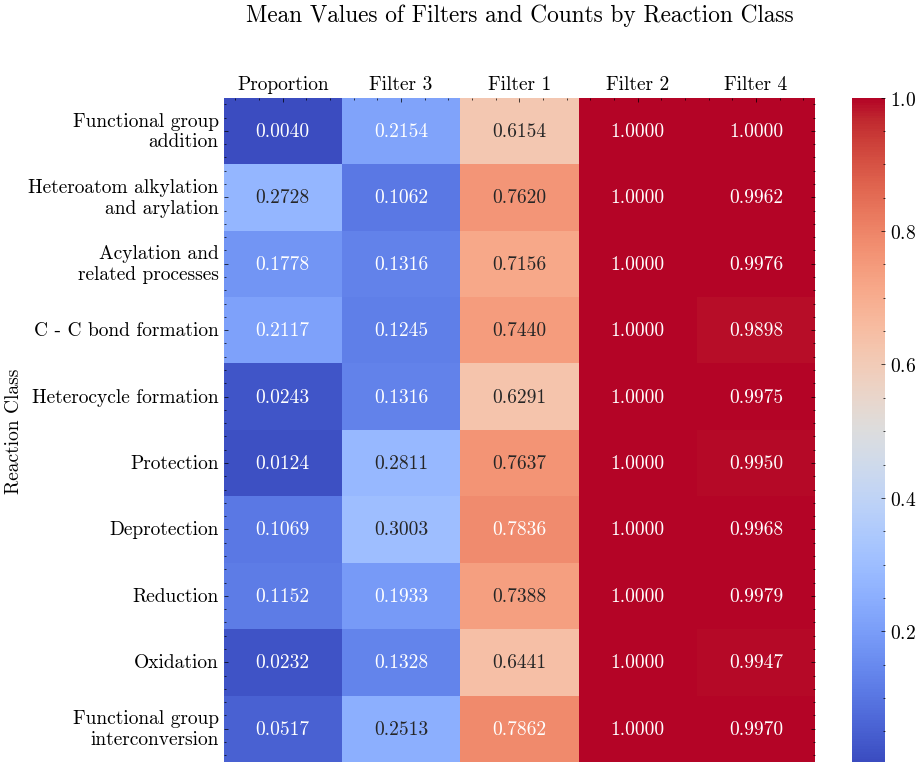

In [ ]:
import seaborn as sns

reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition",
}

heatmap_data = (
    valid_df.groupby("rxn_type")[["Filter_4", "Filter_0", "Filter_2", "Filter_5"]]
    .mean()
    .join(valid_df["rxn_type"].value_counts(normalize=True).rename("Proportion"))
)

heatmap_data.index = heatmap_data.index.map(reaction_data)
heatmap_data = heatmap_data.rename(
    {
        "Filter_4": "Filter 3",
        "Filter_0": "Filter 1",
        "Filter_2": "Filter 2",
        "Filter_5": "Filter 4",
    },
    axis=1,
)
heatmap_data = heatmap_data[
    ["Proportion", "Filter 3", "Filter 1", "Filter 2", "Filter 4"]
]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="coolwarm",
    fmt=".4f",
    cbar_kws={"orientation": "vertical"},
)

# Move the x-axis ticks to the top
plt.xticks(rotation=45, ha="left")  # Rotate for better readability
plt.gca().xaxis.set_ticks_position("top")  # Move x-axis ticks to the top

# Set the title and labels
plt.title("Mean Values of Filters and Counts by Reaction Class\n", pad=20)
plt.ylabel("Reaction Class")

# Save the plot to a file
plt.tight_layout()
plt.savefig(
    os.path.join("results/new", "grid_filters_rxntype.pdf"),
    bbox_inches="tight",
    dpi=500,
)

# Display the plot
plt.show()

In [13]:
reaction_data = {
    "<RX_1>": "Heteroatom alkylation\nand arylation",
    "<RX_2>": "Acylation and\nrelated processes",
    "<RX_3>": "C - C bond formation",
    "<RX_4>": "Heterocycle formation",
    "<RX_5>": "Protection",
    "<RX_6>": "Deprotection",
    "<RX_7>": "Reduction",
    "<RX_8>": "Oxidation",
    "<RX_9>": "Functional group\ninterconversion",
    "<RX_10>": "Functional group\naddition",
}

# Convert reaction codes to descriptions and calculate the frequency
reaction_counts_og = (
    df_with_max_200["reaction_type"]
    .apply(lambda x: reaction_data[x])
    .value_counts(normalize=True)
)
reaction_counts_og

reaction_type
Heteroatom alkylation\nand arylation    0.303501
Acylation and\nrelated processes        0.236329
Deprotection                            0.166578
C - C bond formation                    0.112375
Reduction                               0.092201
Functional group\ninterconversion       0.036835
Heterocycle formation                   0.018152
Oxidation                               0.016332
Protection                              0.013121
Functional group\naddition              0.004576
Name: proportion, dtype: float64

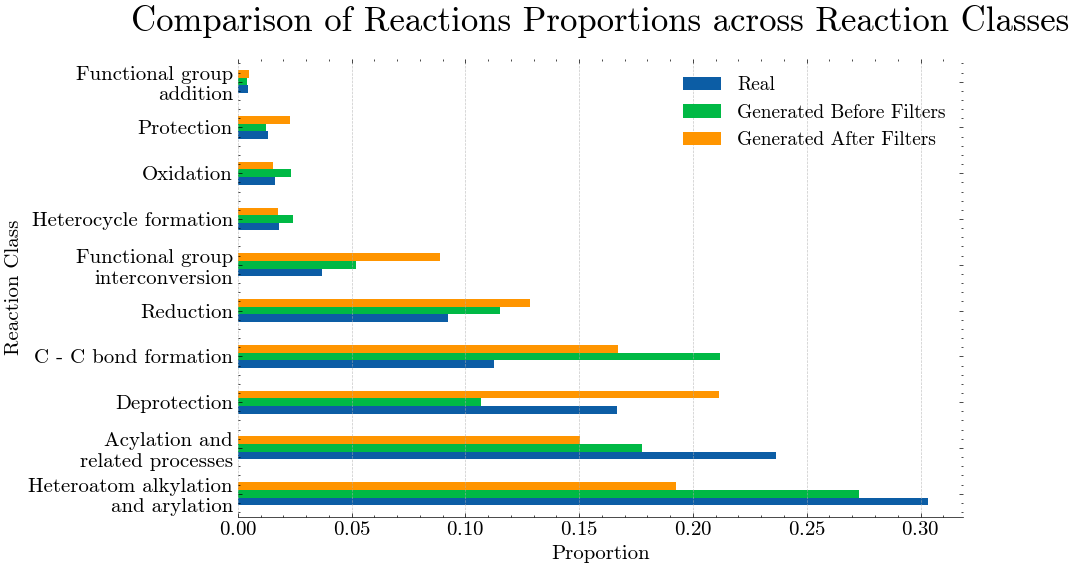

In [ ]:
reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition",
}
reaction_counts_1 = (
    pd.Series(rxn_pred_1).apply(lambda x: reaction_data[x]).value_counts(normalize=True)
)
reaction_counts_2 = (
    pd.Series(rxn_pred_2).apply(lambda x: reaction_data[x]).value_counts(normalize=True)
)
result_df = pd.concat(
    [reaction_counts_og, reaction_counts_1, reaction_counts_2], axis=1
)
result_df.columns = ["Real", "Generated Before Filters", "Generated After Filters"]
result_df.plot(kind="barh", figsize=(10, 6))
plt.title(
    "Comparison of Reactions Proportions across Reaction Classes",
    fontsize=25,
    weight="bold",
    pad=20,
)
plt.xlabel("Proportion", fontsize=15, weight="bold")
plt.ylabel("Reaction Class", fontsize=15, weight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Removing the spines for a cleaner look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/rxn_bar_across_datasets.pdf", bbox_inches="tight", dpi=500)

In [138]:
result_df = pd.concat(
    [reaction_counts_og, lstm_rxn_pred2_counts, vae_rxn_pred2_counts],
    axis=1,
)
result_df.columns = ["Real", "LSTM L=1", "Vanilla VAE"]
result_df

Real  LSTM L=1  Vanilla VAE
Heteroatom alkylation\nand arylation  0.303501  0.212242     0.224343
Acylation and\nrelated processes      0.236329  0.117309     0.147352
Deprotection                          0.166578  0.177881     0.161728
C - C bond formation                  0.112375  0.201694     0.212363
Reduction                             0.092201  0.130734     0.123712
Functional group\ninterconversion     0.036835  0.079431     0.064212
Heterocycle formation                 0.018152  0.030366     0.021883
Oxidation                             0.016332  0.029567     0.025637
Protection                            0.013121  0.016781     0.015973
Functional group\naddition            0.004576  0.003996     0.002795

In [139]:
combined = pd.DataFrame(
    [
        reaction_counts_og,
        vae_rxn_pred1_counts,
        vae_rxn_pred2_counts,
        relative_difference,
    ]
).T
combined.columns = ["Real", "VAE_Before", "VAE_After", "Delta"]
combined

Real  VAE_Before  VAE_After  \
Heteroatom alkylation\nand arylation  0.303501    0.271478   0.224343   
Acylation and\nrelated processes      0.236329    0.180799   0.147352   
Deprotection                          0.166578    0.105601   0.161728   
C - C bond formation                  0.112375    0.219678   0.212363   
Reduction                             0.092201    0.109839   0.123712   
Functional group\ninterconversion     0.036835    0.048003   0.064212   
Heterocycle formation                 0.018152    0.024105   0.021883   
Oxidation                             0.016332    0.024664   0.025637   
Protection                            0.013121    0.012361   0.015973   
Functional group\naddition            0.004576    0.003473   0.002795   

                                         Delta  
Heteroatom alkylation\nand arylation -0.695468  
Acylation and\nrelated processes     -0.699658  
Deprotection                         -0.435619  
C - C bond formation                 -0.643757  
Reduction                            -0.584941  
Functional group\ninterconversion    -0.507051  
Heterocycle formation                -0.665446  
Oxidation                            -0.616945  
Protection                           -0.523810  
Functional group\naddition           -0.703390

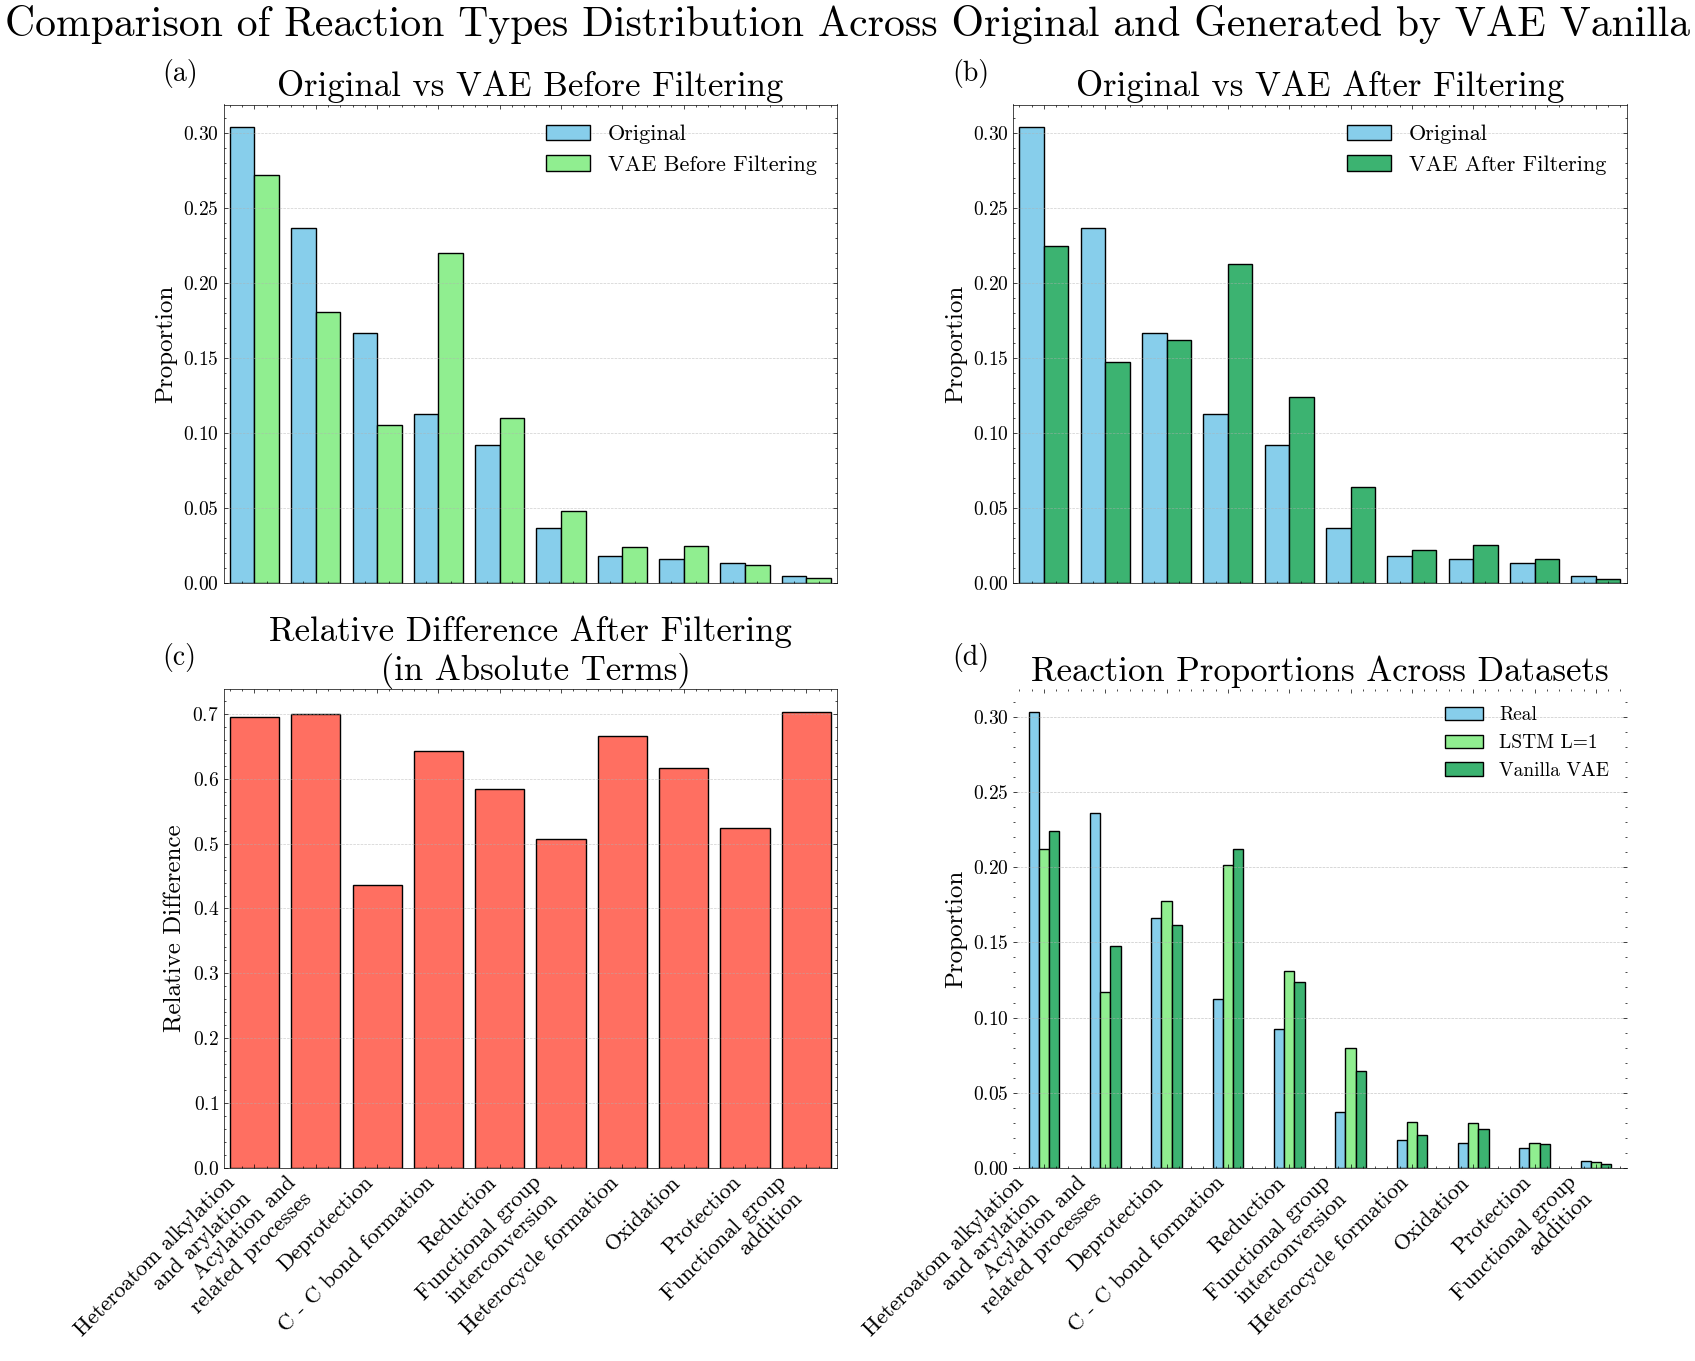

In [146]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define colors
color1 = "#87CEEB"  # Sky Blue
color2 = "#FF6F61"  # Soft Coral
color3 = "#3CB371"  # Medium Sea Green
color4 = "#DAA520"  # Goldenrod

# Create 2x2 subplot layout with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True)

# Plot 1: Original vs VAE Before Filtering
indices = np.arange(len(vae_rxn_pred1_counts.index))
bar_width = 0.4
axes[0, 0].bar(
    indices - bar_width / 2,
    combined["Real"].values,
    bar_width,
    label="Original",
    color=color1,
    edgecolor="black",
)
axes[0, 0].bar(
    indices + bar_width / 2,
    combined["VAE_Before"].values,
    bar_width,
    label="VAE Before Filtering",
    color="lightgreen",
    edgecolor="black",
)
axes[0, 0].set_title("Original vs VAE Before Filtering", fontsize=25)
axes[0, 0].set_ylabel("Proportion", fontsize=18)
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.6)
axes[0, 0].legend(fontsize=16)
axes[0, 0].text(
    -0.1, 1.05, "(a)", transform=axes[0, 0].transAxes, fontsize=20, fontweight="bold"
)

# Plot 2: Original vs VAE After Filtering
indices = np.arange(len(vae_rxn_pred2_counts.index))
axes[0, 1].bar(
    indices - bar_width / 2,
    combined["Real"].values,
    bar_width,
    label="Original",
    color=color1,
    edgecolor="black",
)
axes[0, 1].bar(
    indices + bar_width / 2,
    combined["VAE_After"].values,
    bar_width,
    label="VAE After Filtering",
    color=color3,
    edgecolor="black",
)
axes[0, 1].set_title("Original vs VAE After Filtering", fontsize=25)
axes[0, 1].set_ylabel("Proportion", fontsize=18)
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.6)
axes[0, 1].legend(fontsize=16)
axes[0, 1].text(
    -0.1, 1.05, "(b)", transform=axes[0, 1].transAxes, fontsize=20, fontweight="bold"
)

# Plot 3: Relative Difference in Absolute Terms
axes[1, 0].bar(
    combined["Delta"].index,
    combined["Delta"].abs().values,
    color=color2,
    edgecolor="black",
)
axes[1, 0].set_title(
    "Relative Difference After Filtering\n (in Absolute Terms)", fontsize=25
)
axes[1, 0].set_ylabel("Relative Difference", fontsize=18)
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.6)
axes[1, 0].text(
    -0.1, 1.05, "(c)", transform=axes[1, 0].transAxes, fontsize=20, fontweight="bold"
)

# Plot 4: Comparison Across Reaction Classes (Now Vertical Bar Chart)
result_df.plot(
    kind="bar", ax=axes[1, 1], color=[color1, "lightgreen", color3], edgecolor="black"
)
axes[1, 1].set_title("Reaction Proportions Across Datasets", fontsize=25)
axes[1, 1].set_ylabel("Proportion", fontsize=18)
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1, 1].legend(fontsize=14)
axes[1, 1].spines["top"].set_visible(False)
axes[1, 1].spines["right"].set_visible(False)
axes[1, 1].spines["left"].set_visible(False)
axes[1, 1].text(
    -0.1, 1.05, "(d)", transform=axes[1, 1].transAxes, fontsize=20, fontweight="bold"
)

# Set x-ticks for all subplots with larger font size
for ax in axes.flat:
    ax.set_xticks(indices)
    ax.set_xticklabels(reaction_counts_og.index, rotation=45, ha="right", fontsize=16)

# Adjust layout
plt.suptitle(
    "Comparison of Reaction Types Distribution Across Original and Generated by VAE Vanilla",
    fontsize=30,
    weight="bold",
)
plt.tight_layout()

# Save the figure
plt.savefig(
    "results/new/reaction_types_comparison_combined.jpeg", bbox_inches="tight", dpi=500
)


## Model Performance

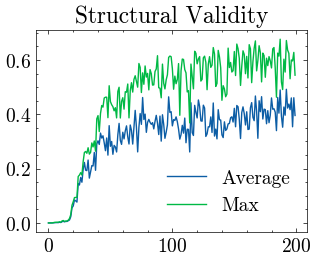

Avg Validity 0.4921 192 Maximum: 0.6717 Std: 0.1444
Max Validity 0.6765 187 Average: 0.4896 Std: 0.1814


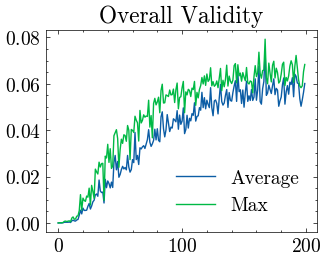

Avg Overall Validity 0.0743 167 Maximum: 0.0792 Std: 0.0029
Max Overall Validity 0.0792 167 Average: 0.0743 Std: 0.0029


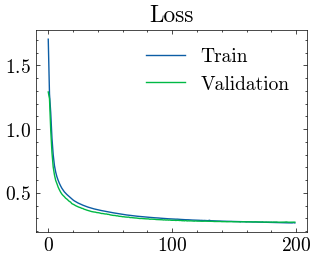

186
0.2694 0.2702


In [ ]:
import re
import matplotlib.pyplot as plt

logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print(
    "Avg Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)
patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print(
    "Avg Overall Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Overall Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)
patt = re.compile("val loss:  (\d.\d\d\d\d)")
val_losses = patt.findall(logv2_str)
patt = re.compile("Train Loss: (\d.\d\d\d\d\d)")
train_losses = patt.findall(logv2_str)
train_losses = [float(loss) for loss in train_losses]
val_losses = [float(loss) for loss in val_losses]
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show()
print(np.argmin(val_losses))
print(np.min(val_losses), val_losses[-1])

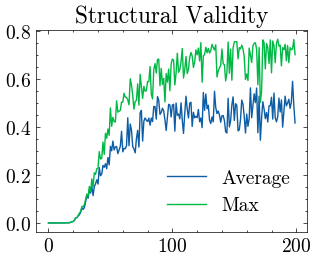

Avg Validity 0.5903 197 Maximum: 0.725 Std: 0.17
Max Validity 0.7659 185 Average: 0.442 Std: 0.235


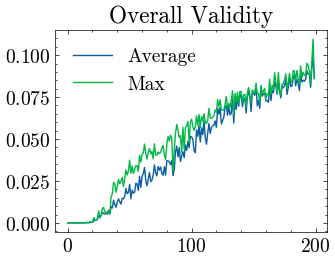

Avg Overall Validity 0.0996 198 Maximum: 0.1095 Std: 0.0065
Max Overall Validity 0.1095 198 Average: 0.0996 Std: 0.0065


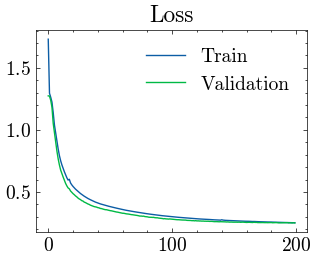

199
0.2505 0.2505


In [ ]:
import re
import matplotlib.pyplot as plt

logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2.2/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print(
    "Avg Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)
patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print(
    "Avg Overall Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Overall Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)
patt = re.compile("val loss:  (\d.\d\d\d\d)")
val_losses = patt.findall(logv2_str)
patt = re.compile("Train Loss: (\d.\d\d\d\d\d)")
train_losses = patt.findall(logv2_str)
train_losses = [float(loss) for loss in train_losses]
val_losses = [float(loss) for loss in val_losses]
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show()
print(np.argmin(val_losses))
print(np.min(val_losses), val_losses[-1])

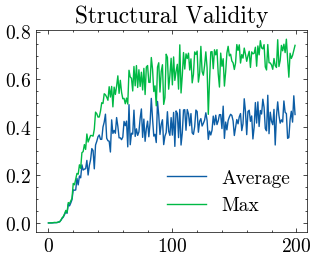

Avg Validity 0.5341 177 Maximum: 0.7462 Std: 0.2495
Max Validity 0.7685 192 Average: 0.4576 Std: 0.1961


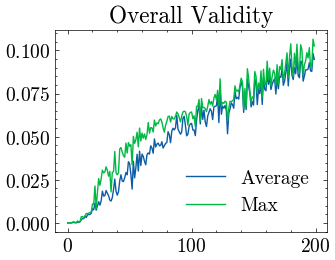

Avg Overall Validity 0.0982 198 Maximum: 0.1065 Std: 0.0054
Max Overall Validity 0.1065 198 Average: 0.0982 Std: 0.0054


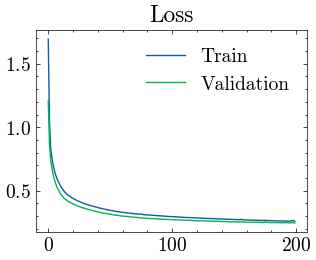

194
0.2445 0.2445


In [ ]:
import re
import matplotlib.pyplot as plt

logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2.3/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print(
    "Avg Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)
patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print(
    "Avg Overall Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Overall Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)
patt = re.compile("val loss:  (\d.\d\d\d\d)")
val_losses = patt.findall(logv2_str)
patt = re.compile("Train Loss: (\d.\d\d\d\d\d)")
train_losses = patt.findall(logv2_str)
train_losses = [float(loss) for loss in train_losses]
val_losses = [float(loss) for loss in val_losses]
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show()
print(np.argmin(val_losses))
print(np.min(val_losses), val_losses[-1])

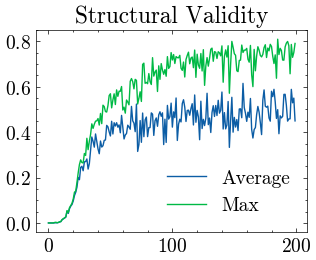

Avg Validity 0.6151 157 Maximum: 0.7514 Std: 0.1534
Max Validity 0.8098 185 Average: 0.4992 Std: 0.2302


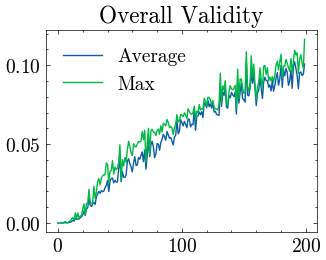

Avg Overall Validity 0.1022 191 Maximum: 0.1095 Std: 0.006
Max Overall Validity 0.1165 199 Average: 0.1007 Std: 0.0127


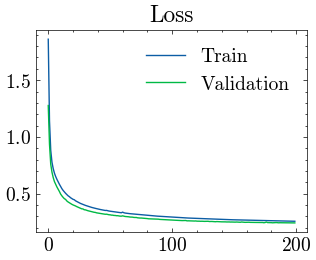

197
0.2428 0.2432


In [ ]:
import re
import matplotlib.pyplot as plt

logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2.4/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print(
    "Avg Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)
patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print(
    "Avg Overall Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Overall Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)
patt = re.compile("val loss:  (\d.\d\d\d\d)")
val_losses = patt.findall(logv2_str)
patt = re.compile("Train Loss: (\d.\d\d\d\d\d)")
train_losses = patt.findall(logv2_str)
train_losses = [float(loss) for loss in train_losses]
val_losses = [float(loss) for loss in val_losses]
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.show()
print(np.argmin(val_losses))
print(np.min(val_losses), val_losses[-1])

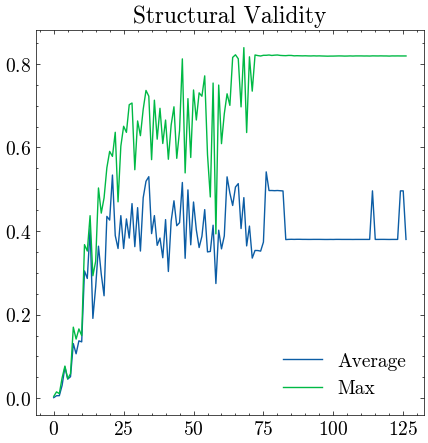

Avg Structural Validity 0.5415 76 Maximum: 0.8204 Std: 0.2494
Max Structural Validity 0.8387 68 Average: 0.4799 Std: 0.2462


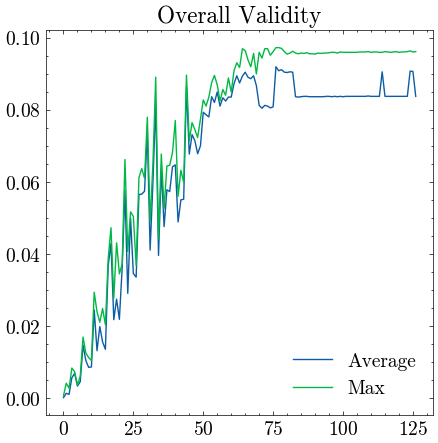

Avg Overall Validity 0.0919 76 Maximum: 0.0972 Std: 0.0032
Max Overall Validity 0.0972 76 Average: 0.0919 Std: 0.0032


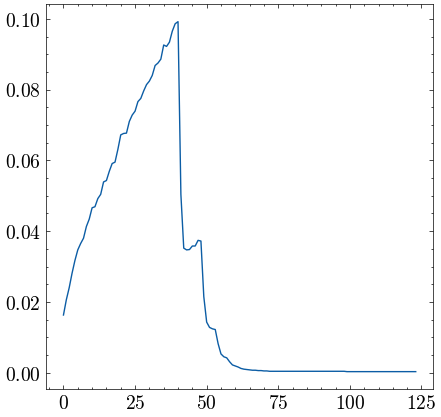

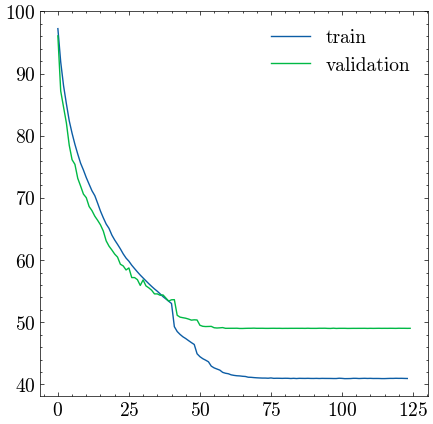

65


In [ ]:
import re
import matplotlib.pyplot as plt

logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v4/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print(
    "Avg Structural Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Structural Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)

patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print(
    "Avg Overall Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Overall Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)

patt = re.compile("epoch: \d+, avg_loss: \d\d.\d\d\d\d, kl: (\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
vals = [float(val) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(vals)
plt.show()

patt = re.compile("epoch: \d+, avg_loss: (\d\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
train_vals = [float(val) for val in vals]
patt = re.compile("VAL --- avg_loss: (\d\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
valid_vals = [float(val) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(train_vals, label="train")
plt.plot(valid_vals, label="validation")
plt.legend()
plt.show()
print(np.argmin(valid_vals))

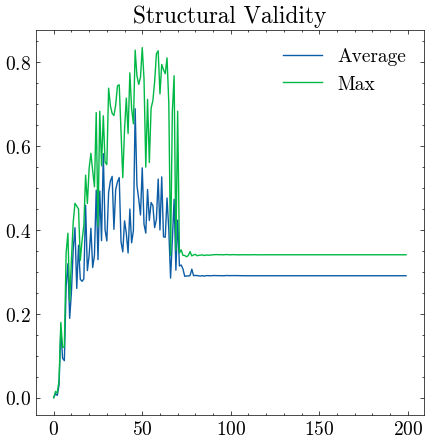

Avg Structural Validity 0.6894 46 Maximum: 0.829 Std: 0.1831
Max Structural Validity 0.835 50 Average: 0.5483 Std: 0.2815


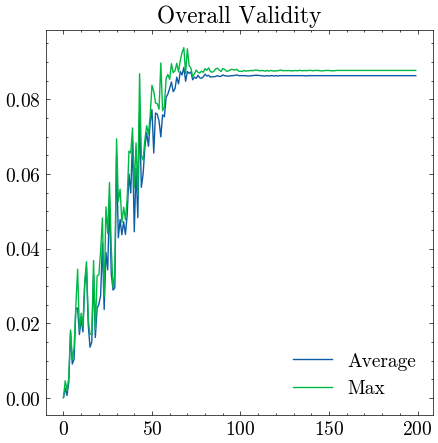

Avg Overall Validity 0.0885 68 Maximum: 0.0938 Std: 0.0042
Max Overall Validity 0.0938 68 Average: 0.0885 Std: 0.0042


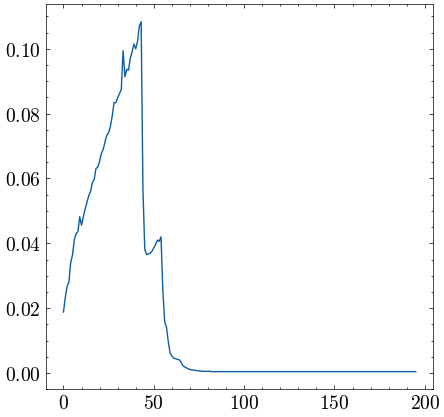

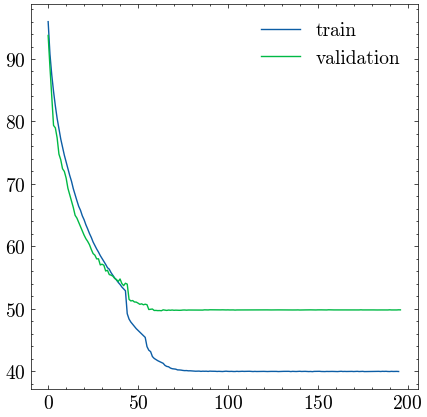

63


In [ ]:
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v4.2/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "- Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Structural Validity")
plt.legend()
plt.show()
print(
    "Avg Structural Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Structural Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)

patt = re.compile(
    "- Overall Validity          (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)"
)
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.title("Overall Validity")
plt.legend()
plt.show()
print(
    "Avg Overall Validity",
    np.max(avg_vals),
    np.argmax(avg_vals),
    "Maximum:",
    max_vals[np.argmax(avg_vals)],
    "Std:",
    std_vals[np.argmax(avg_vals)],
)
print(
    "Max Overall Validity",
    np.max(max_vals),
    np.argmax(max_vals),
    "Average:",
    avg_vals[np.argmax(max_vals)],
    "Std:",
    std_vals[np.argmax(max_vals)],
)

patt = re.compile("epoch: \d+, avg_loss: \d\d.\d\d\d\d, kl: (\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
vals = [float(val) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(vals)
plt.show()

patt = re.compile("epoch: \d+, avg_loss: (\d\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
train_vals = [float(val) for val in vals]
patt = re.compile("VAL --- avg_loss: (\d\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
valid_vals = [float(val) for val in vals]
plt.figure(figsize=(5, 5))
plt.plot(train_vals, label="train")
plt.plot(valid_vals, label="validation")
plt.legend()
plt.show()
print(np.argmin(valid_vals))

## Comparing the Reactions Distributions of All Models

In [ ]:
def get_rxns(generator, evaluator, generated_path):
    # Initialize metrics dictionary
    metrics = {"rxn_pred": [], "div_class_df": []}

    seeds = [42, 0, 250, 1000, 350]

    for seed in seeds:
        generator.generate_samples(seed=seed)
        evaluator.generate_metrics_evaluation(generated_path)
        metrics["rxn_pred"].append(evaluator.rxn_pred)
        metrics["div_class_df"].append(evaluator.div_class_df)
    return metrics

In [ ]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_1layer_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
metrics = get_rxns(generator, evaluator, config["gene_path"])

generating with LSTM


/home/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_

In [ ]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/VAE_vanilla_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
vae_metrics = get_rxns(generator, evaluator, config["gene_path"])

generating with VAE


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

In [ ]:
for i in range(len(metrics["div_class_df"])):
    sums = metrics["div_class_df"][i]["count"].sum()
    metrics["div_class_df"][i]["perc"] = metrics["div_class_df"][i]["count"] / sums
all_dfs = (
    pd.concat(metrics["div_class_df"], axis=0, ignore_index=True)
    .groupby("label", as_index=False)
    .agg(
        {
            "count": "mean",
            "VS": "mean",
            "AvgInterSim": "mean",
            "VS_norm": "mean",
            "perc": "mean",
        }
    )
)
all_dfs

label   count           VS  AvgInterSim   VS_norm      perc
0      0    19.6    19.160723     0.959254  0.978884  0.003064
1      1  1377.8  1067.719515     0.965869  0.775097  0.214970
2      2   797.2   657.367288     0.963850  0.824792  0.124371
3      3  1303.4  1024.478983     0.966377  0.786132  0.203348
4      4   202.0   186.402184     0.965446  0.922812  0.031519
5      5   110.6    75.423260     0.884314  0.685641  0.017246
6      6  1132.6   832.023239     0.957452  0.734697  0.176762
7      7   794.4   602.449843     0.964043  0.758484  0.124005
8      8   192.0   177.376940     0.965405  0.924032  0.029942
9      9   478.8   288.146554     0.967916  0.601906  0.074773

In [ ]:
for i in range(len(vae_metrics["div_class_df"])):
    sums = vae_metrics["div_class_df"][i]["count"].sum()
    vae_metrics["div_class_df"][i]["perc"] = (
        vae_metrics["div_class_df"][i]["count"] / sums
    )
vae_all_dfs = (
    pd.concat(vae_metrics["div_class_df"], axis=0, ignore_index=True)
    .groupby("label", as_index=False)
    .agg(
        {
            "count": "mean",
            "VS": "mean",
            "AvgInterSim": "mean",
            "VS_norm": "mean",
            "perc": "mean",
        }
    )
)
vae_all_dfs

label   count           VS  AvgInterSim   VS_norm      perc
0      0    33.8    30.704764     0.933070  0.909039  0.002707
1      1  2762.6  1912.217132     0.967473  0.692244  0.221249
2      2  1872.6  1367.920089     0.964513  0.730508  0.149978
3      3  2657.2  1888.353470     0.967896  0.710658  0.212823
4      4   288.2   262.531404     0.966332  0.911116  0.023083
5      5   203.2   131.359806     0.904717  0.646492  0.016278
6      6  2040.8  1353.762526     0.956790  0.663416  0.163460
7      7  1548.0  1037.455145     0.962268  0.670290  0.123976
8      8   286.8   259.376472     0.965282  0.904592  0.022970
9      9   792.6   553.553345     0.972813  0.699454  0.063476

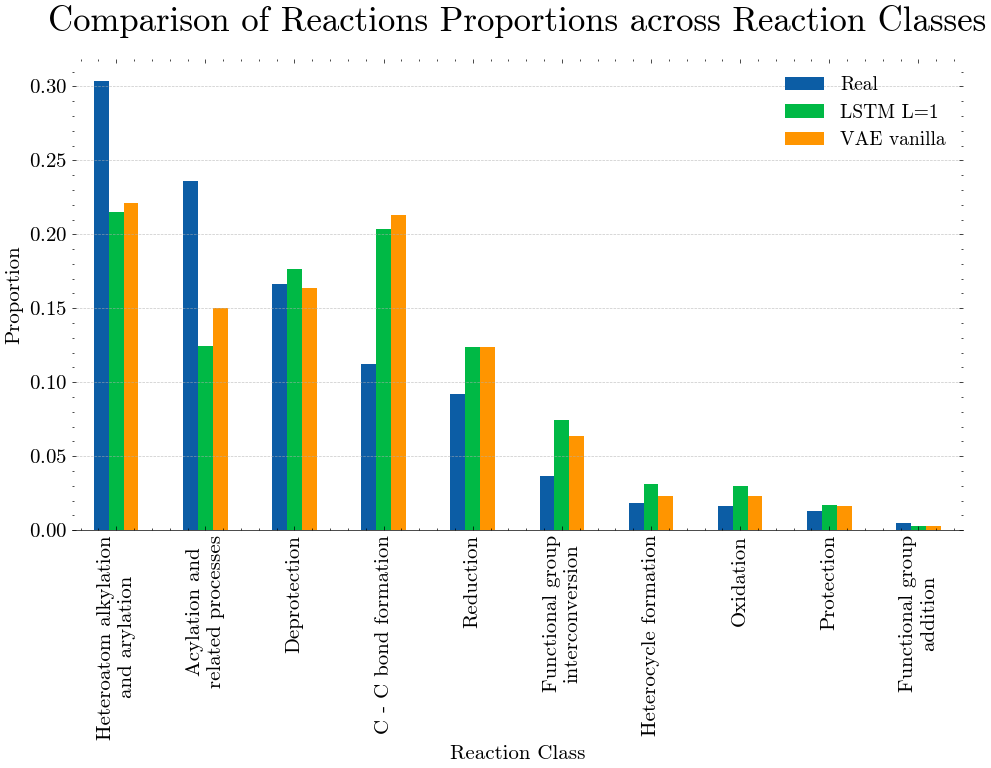

In [ ]:
reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition",
}
all_dfs["Reaction_Class"] = all_dfs["label"].apply(lambda x: reaction_data[x])
vae_all_dfs["Reaction_Class"] = vae_all_dfs["label"].apply(lambda x: reaction_data[x])
reaction_counts_1 = all_dfs.set_index("Reaction_Class")["perc"]
reaction_counts_2 = vae_all_dfs.set_index("Reaction_Class")["perc"]
result_df = pd.concat(
    [reaction_counts_og, reaction_counts_1, reaction_counts_2], axis=1
)
result_df.columns = ["Real", "LSTM L=1", "VAE vanilla"]
result_df.plot(kind="bar", figsize=(10, 8))
plt.title(
    "Comparison of Reactions Proportions across Reaction Classes",
    fontsize=25,
    weight="bold",
    pad=20,
)
plt.ylabel("Proportion", fontsize=15, weight="bold")
plt.xlabel("Reaction Class", fontsize=15, weight="bold")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Removing the spines for a cleaner look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/rxn_bar_across_models.pdf", bbox_inches="tight", dpi=500)

In [ ]:
reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition",
}
all_dfs["Reaction_Class"] = all_dfs["label"].apply(lambda x: reaction_data[x])
vae_all_dfs["Reaction_Class"] = vae_all_dfs["label"].apply(lambda x: reaction_data[x])
reaction_counts_1 = all_dfs.set_index("Reaction_Class")["VS_norm"]
reaction_counts_2 = vae_all_dfs.set_index("Reaction_Class")["VS_norm"]
result_df = pd.concat([reaction_counts_1, reaction_counts_2], axis=1)
result_df.columns = ["LSTM L=1", "VAE Vanilla"]
result_df

LSTM L=1  VAE Vanilla
Reaction_Class                                             
Functional group\naddition            0.978884     0.909039
Heteroatom alkylation\nand arylation  0.775097     0.692244
Acylation and\nrelated processes      0.824792     0.730508
C - C bond formation                  0.786132     0.710658
Heterocycle formation                 0.922812     0.911116
Protection                            0.685641     0.646492
Deprotection                          0.734697     0.663416
Reduction                             0.758484     0.670290
Oxidation                             0.924032     0.904592
Functional group\ninterconversion     0.601906     0.699454

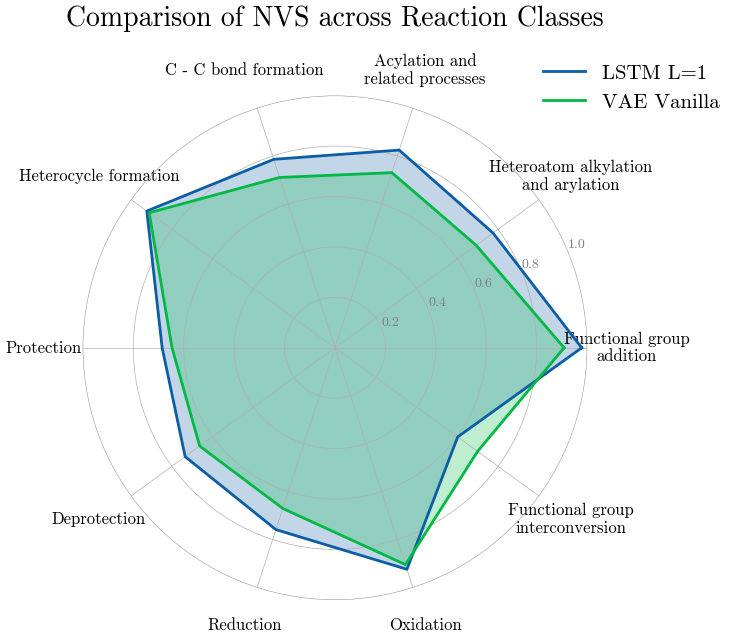

In [ ]:
from math import pi
import matplotlib.pyplot as plt

# Prepare data for radar chart
categories = result_df.index
num_vars = len(categories)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the circle

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot each model
for column in result_df.columns:
    values = result_df[column].tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, linewidth=2, linestyle="solid", label=column)
    ax.fill(angles, values, alpha=0.25)

# Customize the radar chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, ha="center")

# Adjust the label distance from the chart
for label, angle in zip(ax.get_xticklabels(), angles):
    x, y = label.get_position()
    label.set_position((x, y - 0.1))  # Adjust the value of 0.1 as needed

ax.spines["polar"].set_color("gray")
ax.spines["polar"].set_linewidth(0.2)
plt.title("Comparison of NVS across Reaction Classes", fontsize=20, pad=20)
plt.legend(loc="upper right", fontsize=15, bbox_to_anchor=(1.3, 1.1))

# Add grid numbers (scale)
ax.set_rscale("linear")  # Set scale type
max_value = 1  # Find the max value for grid scale
num_levels = 5  # Define the number of grid levels
grid_values = [round(max_value * i / num_levels, 2) for i in range(1, num_levels + 1)]
ax.set_yticks(grid_values)
ax.set_yticklabels(grid_values, fontsize=10, color="gray")

# Save or display
plt.tight_layout()
plt.savefig("results/new/rxn_NVS_radar_chart.pdf", bbox_inches="tight", dpi=500)
plt.show()


In [ ]:
reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition",
}
reaction_counts_1 = all_dfs.set_index("Reaction_Class")["AvgInterSim"]
reaction_counts_2 = vae_all_dfs.set_index("Reaction_Class")["AvgInterSim"]
result_df = pd.concat([reaction_counts_1, reaction_counts_2], axis=1)
result_df.columns = ["LSTM L=1", "VAE Vanilla"]
result_df

LSTM L=1  VAE Vanilla
Reaction_Class                                             
Functional group\naddition            0.959254     0.933070
Heteroatom alkylation\nand arylation  0.965869     0.967473
Acylation and\nrelated processes      0.963850     0.964513
C - C bond formation                  0.966377     0.967896
Heterocycle formation                 0.965446     0.966332
Protection                            0.884314     0.904717
Deprotection                          0.957452     0.956790
Reduction                             0.964043     0.962268
Oxidation                             0.965405     0.965282
Functional group\ninterconversion     0.967916     0.972813

In [ ]:
latex_table = result_df.to_latex(
    index=True,  # Include index in the LaTeX output
    header=True,  # Include column headers
    caption="Comparison of NVS Across Reaction Classes",
    label="tab:nvs_comparison",
    float_format="%.4f",  # Format for float numbers
)
with open("results/new/nvs_comparison_table.tex", "w") as f:
    f.write(latex_table)

## Model Performance based on Evaluation Metrics

In [8]:
def generate_and_evaluate(generator, evaluator, generated_path):
    # Initialize metrics dictionary
    metrics = {
        "JSS": [],
        "Similarity": [],
        "String Similarity": [],
        "Validity": [],
        "Novelty Percentage": [],
        "Unique Percentage": [],
        "Average Inter Dissimilarity": [],
        "Overall Validity": [],
        "Normalized Vendi Score": [],
        "Normalized Vendi Score (q=0.1)": [],
        "Normalized Vendi Score (q=inf)": [],
        "Avg Normalized Vendi Score Per Class": [],
        "Filter 1": [],
        "Filter 2": [],
        "Filter 3": [],
        "Filter 4": [],
    }

    seeds = [42, 0, 250, 1000, 350]

    for seed in seeds:
        generator.generate_samples(seed=seed)
        evaluator.generate_metrics_evaluation(generated_path)
        metrics["JSS"].append(evaluator.results["jss"])
        metrics["Similarity"].append(evaluator.results["avg_similarity"])
        metrics["String Similarity"].append(evaluator.results["avg_str_similarity"])
        metrics["Validity"].append(evaluator.results["valid"])
        metrics["Novelty Percentage"].append(evaluator.results["novelty_perc"])
        metrics["Unique Percentage"].append(evaluator.results["unique_perc"])
        metrics["Average Inter Dissimilarity"].append(
            evaluator.results["average_inter_dissimilarity"]
        )
        metrics["Overall Validity"].append(evaluator.results["validated"])
        metrics["Normalized Vendi Score"].append(evaluator.results["vendi_score_k"])
        metrics["Normalized Vendi Score (q=0.1)"].append(
            evaluator.results["vendi_score_k_small"]
        )
        metrics["Normalized Vendi Score (q=inf)"].append(
            evaluator.results["vendi_score_k_inf"]
        )
        metrics["Avg Normalized Vendi Score Per Class"].append(
            evaluator.results["avg_vs_score_per_class"]
        )
        metrics["Filter 1"].append(evaluator.results["filter1"])
        metrics["Filter 2"].append(evaluator.results["filter2"])
        metrics["Filter 3"].append(evaluator.results["filter3"])
        metrics["Filter 4"].append(evaluator.results["filter4"])

        # Print the results for the current seed
        print(f"""Seed {seed}: JSS={evaluator.results["jss"]:.4f}, Sim={evaluator.results["avg_similarity"]:.4f}, StrSim={evaluator.results["avg_str_similarity"]:.4f}, Val={evaluator.results["valid"]:.4f}, NoveltyPerc={evaluator.results["novelty_perc"]:.4f}, 
            UniquePerc={evaluator.results["unique_perc"]:.4f}, IntDiv={evaluator.results["average_inter_dissimilarity"]:.4f}, OverallVal={evaluator.results["validated"]:.4f}, 
            NVS={evaluator.results["vendi_score_k"]:.4f}, NVS(q=0.1)={evaluator.results["vendi_score_k_small"]:.4f}, NVS(q=inf)={evaluator.results["vendi_score_k_inf"]:.4f}, AvgNVSPerClass={evaluator.results["avg_vs_score_per_class"]:.4f}""")

    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"{'Metric':<25} {'Avg':<8} {'Std':<8} {'Min':<8} {'Max':<8}")

    for metric, values in metrics.items():
        print(
            f"{metric:<25} {np.mean(values):<8.4f} {np.std(values):<8.4f} {np.min(values):<8.4f} {np.max(values):<8.4f}"
        )

### V2.1 (LSTM 1 Layer)

In [11]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_1layer_best_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
/home/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_

Seed 42: JSS=0.8425, Sim=0.1570, StrSim=0.8718, Val=0.6783, NoveltyPerc=0.9992, 
            UniquePerc=0.9986, IntDiv=0.9706, OverallVal=0.2124, 
            NVS=0.5123, NVS(q=0.1)=0.9515, NVS(q=inf)=0.0038, AvgNVSPerClass=0.7749
Seed 0: JSS=0.8480, Sim=0.1571, StrSim=0.8718, Val=0.6825, NoveltyPerc=0.9993, 
            UniquePerc=0.9983, IntDiv=0.9708, OverallVal=0.2106, 
            NVS=0.5156, NVS(q=0.1)=0.9514, NVS(q=inf)=0.0039, AvgNVSPerClass=0.7773
Seed 250: JSS=0.8398, Sim=0.1578, StrSim=0.8720, Val=0.6725, NoveltyPerc=0.9993, 
            UniquePerc=0.9982, IntDiv=0.9710, OverallVal=0.2128, 
            NVS=0.5135, NVS(q=0.1)=0.9517, NVS(q=inf)=0.0038, AvgNVSPerClass=0.7758
Seed 1000: JSS=0.8355, Sim=0.1576, StrSim=0.8722, Val=0.6784, NoveltyPerc=0.9996, 
            UniquePerc=0.9983, IntDiv=0.9711, OverallVal=0.2118, 
            NVS=0.5117, NVS(q=0.1)=0.9501, NVS(q=inf)=0.0039, AvgNVSPerClass=0.7630
Seed 350: JSS=0.8448, Sim=0.1596, StrSim=0.8717, Val=0.6824, NoveltyPerc=0

In [12]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_1layer_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
/home/anis/miniconda3/envs/chemgen_env/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_

Seed 42: JSS=0.8371, Sim=0.1524, StrSim=0.8678, Val=0.6298, NoveltyPerc=0.9995, 
            UniquePerc=0.9989, IntDiv=0.9704, OverallVal=0.1611, 
            NVS=0.5711, NVS(q=0.1)=0.9575, NVS(q=inf)=0.0050, AvgNVSPerClass=0.8063
Seed 0: JSS=0.8378, Sim=0.1523, StrSim=0.8678, Val=0.6351, NoveltyPerc=0.9989, 
            UniquePerc=0.9994, IntDiv=0.9705, OverallVal=0.1626, 
            NVS=0.5746, NVS(q=0.1)=0.9598, NVS(q=inf)=0.0050, AvgNVSPerClass=0.8116
Seed 250: JSS=0.8462, Sim=0.1537, StrSim=0.8671, Val=0.6315, NoveltyPerc=0.9989, 
            UniquePerc=0.9992, IntDiv=0.9705, OverallVal=0.1631, 
            NVS=0.5698, NVS(q=0.1)=0.9579, NVS(q=inf)=0.0049, AvgNVSPerClass=0.7962
Seed 1000: JSS=0.8310, Sim=0.1557, StrSim=0.8681, Val=0.6288, NoveltyPerc=0.9994, 
            UniquePerc=0.9986, IntDiv=0.9709, OverallVal=0.1587, 
            NVS=0.5679, NVS(q=0.1)=0.9554, NVS(q=inf)=0.0051, AvgNVSPerClass=0.7942
Seed 350: JSS=0.8370, Sim=0.1565, StrSim=0.8680, Val=0.6373, NoveltyPerc=0

### V2.2 (LSTM 2 Layers)

In [13]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_2layers_best_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8532, Sim=0.1633, StrSim=0.8651, Val=0.7757, NoveltyPerc=0.9995, 
            UniquePerc=0.9984, IntDiv=0.9721, OverallVal=0.2780, 
            NVS=0.4782, NVS(q=0.1)=0.9444, NVS(q=inf)=0.0030, AvgNVSPerClass=0.7405
Seed 0: JSS=0.8581, Sim=0.1642, StrSim=0.8654, Val=0.7757, NoveltyPerc=0.9994, 
            UniquePerc=0.9986, IntDiv=0.9721, OverallVal=0.2783, 
            NVS=0.4786, NVS(q=0.1)=0.9445, NVS(q=inf)=0.0030, AvgNVSPerClass=0.7347
Seed 250: JSS=0.8509, Sim=0.1614, StrSim=0.8650, Val=0.7723, NoveltyPerc=0.9994, 
            UniquePerc=0.9993, IntDiv=0.9718, OverallVal=0.2739, 
            NVS=0.4838, NVS(q=0.1)=0.9466, NVS(q=inf)=0.0031, AvgNVSPerClass=0.7357
Seed 1000: JSS=0.8565, Sim=0.1614, StrSim=0.8653, Val=0.7743, NoveltyPerc=0.9994, 
            UniquePerc=0.9991, IntDiv=0.9720, OverallVal=0.2734, 
            NVS=0.4841, NVS(q=0.1)=0.9463, NVS(q=inf)=0.0031, AvgNVSPerClass=0.7444
Seed 350: JSS=0.8537, Sim=0.1624, StrSim=0.8657, Val=0.7759, NoveltyPerc=0

In [14]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_2layers_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8505, Sim=0.1597, StrSim=0.8661, Val=0.7441, NoveltyPerc=0.9992, 
            UniquePerc=0.9988, IntDiv=0.9716, OverallVal=0.2411, 
            NVS=0.5102, NVS(q=0.1)=0.9515, NVS(q=inf)=0.0035, AvgNVSPerClass=0.7657
Seed 0: JSS=0.8459, Sim=0.1597, StrSim=0.8661, Val=0.7435, NoveltyPerc=0.9994, 
            UniquePerc=0.9984, IntDiv=0.9719, OverallVal=0.2420, 
            NVS=0.5088, NVS(q=0.1)=0.9490, NVS(q=inf)=0.0035, AvgNVSPerClass=0.7582
Seed 250: JSS=0.8427, Sim=0.1579, StrSim=0.8654, Val=0.7462, NoveltyPerc=0.9993, 
            UniquePerc=0.9994, IntDiv=0.9715, OverallVal=0.2415, 
            NVS=0.5107, NVS(q=0.1)=0.9499, NVS(q=inf)=0.0034, AvgNVSPerClass=0.7614
Seed 1000: JSS=0.8500, Sim=0.1588, StrSim=0.8657, Val=0.7438, NoveltyPerc=0.9995, 
            UniquePerc=0.9997, IntDiv=0.9719, OverallVal=0.2413, 
            NVS=0.5122, NVS(q=0.1)=0.9510, NVS(q=inf)=0.0035, AvgNVSPerClass=0.7705
Seed 350: JSS=0.8500, Sim=0.1579, StrSim=0.8659, Val=0.7470, NoveltyPerc=0

### V2.3 (LSTM 3 Layers)

In [9]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_3layers_best_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8605, Sim=0.1606, StrSim=0.8640, Val=0.7762, NoveltyPerc=0.9987, 
            UniquePerc=0.9980, IntDiv=0.9726, OverallVal=0.2766, 
            NVS=0.4858, NVS(q=0.1)=0.9436, NVS(q=inf)=0.0031, AvgNVSPerClass=0.7439
Seed 0: JSS=0.8637, Sim=0.1602, StrSim=0.8639, Val=0.7789, NoveltyPerc=0.9991, 
            UniquePerc=0.9991, IntDiv=0.9725, OverallVal=0.2803, 
            NVS=0.4868, NVS(q=0.1)=0.9452, NVS(q=inf)=0.0031, AvgNVSPerClass=0.7369
Seed 250: JSS=0.8593, Sim=0.1590, StrSim=0.8632, Val=0.7759, NoveltyPerc=0.9995, 
            UniquePerc=0.9989, IntDiv=0.9724, OverallVal=0.2782, 
            NVS=0.4880, NVS(q=0.1)=0.9451, NVS(q=inf)=0.0031, AvgNVSPerClass=0.7432
Seed 1000: JSS=0.8611, Sim=0.1587, StrSim=0.8641, Val=0.7767, NoveltyPerc=0.9992, 
            UniquePerc=0.9993, IntDiv=0.9724, OverallVal=0.2767, 
            NVS=0.4892, NVS(q=0.1)=0.9465, NVS(q=inf)=0.0031, AvgNVSPerClass=0.7466
Seed 350: JSS=0.8643, Sim=0.1604, StrSim=0.8637, Val=0.7791, NoveltyPerc=0

In [10]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_3layers_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8453, Sim=0.1665, StrSim=0.8658, Val=0.7620, NoveltyPerc=0.9982, 
            UniquePerc=0.9970, IntDiv=0.9731, OverallVal=0.2573, 
            NVS=0.4911, NVS(q=0.1)=0.9437, NVS(q=inf)=0.0034, AvgNVSPerClass=0.7459
Seed 0: JSS=0.8476, Sim=0.1664, StrSim=0.8653, Val=0.7642, NoveltyPerc=0.9991, 
            UniquePerc=0.9979, IntDiv=0.9733, OverallVal=0.2550, 
            NVS=0.4933, NVS(q=0.1)=0.9437, NVS(q=inf)=0.0035, AvgNVSPerClass=0.7415
Seed 250: JSS=0.8454, Sim=0.1631, StrSim=0.8649, Val=0.7621, NoveltyPerc=0.9993, 
            UniquePerc=0.9989, IntDiv=0.9734, OverallVal=0.2534, 
            NVS=0.5014, NVS(q=0.1)=0.9455, NVS(q=inf)=0.0035, AvgNVSPerClass=0.7444
Seed 1000: JSS=0.8394, Sim=0.1662, StrSim=0.8652, Val=0.7592, NoveltyPerc=0.9992, 
            UniquePerc=0.9988, IntDiv=0.9732, OverallVal=0.2526, 
            NVS=0.4945, NVS(q=0.1)=0.9444, NVS(q=inf)=0.0035, AvgNVSPerClass=0.7420
Seed 350: JSS=0.8508, Sim=0.1670, StrSim=0.8651, Val=0.7646, NoveltyPerc=0

### V2.4 (LSTM 4 Layers)

In [11]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_4layers_best_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8454, Sim=0.1615, StrSim=0.8653, Val=0.8011, NoveltyPerc=0.9993, 
            UniquePerc=0.9985, IntDiv=0.9727, OverallVal=0.2794, 
            NVS=0.4885, NVS(q=0.1)=0.9475, NVS(q=inf)=0.0031, AvgNVSPerClass=0.7499
Seed 0: JSS=0.8487, Sim=0.1602, StrSim=0.8652, Val=0.8026, NoveltyPerc=0.9990, 
            UniquePerc=0.9988, IntDiv=0.9727, OverallVal=0.2847, 
            NVS=0.4854, NVS(q=0.1)=0.9468, NVS(q=inf)=0.0030, AvgNVSPerClass=0.7398
Seed 250: JSS=0.8499, Sim=0.1609, StrSim=0.8653, Val=0.7993, NoveltyPerc=0.9992, 
            UniquePerc=0.9989, IntDiv=0.9727, OverallVal=0.2795, 
            NVS=0.4879, NVS(q=0.1)=0.9473, NVS(q=inf)=0.0031, AvgNVSPerClass=0.7452
Seed 1000: JSS=0.8478, Sim=0.1605, StrSim=0.8651, Val=0.8032, NoveltyPerc=0.9991, 
            UniquePerc=0.9988, IntDiv=0.9726, OverallVal=0.2821, 
            NVS=0.4896, NVS(q=0.1)=0.9482, NVS(q=inf)=0.0031, AvgNVSPerClass=0.7459
Seed 350: JSS=0.8546, Sim=0.1608, StrSim=0.8650, Val=0.8025, NoveltyPerc=0

In [12]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/LSTM_4layers_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with LSTM


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8510, Sim=0.1594, StrSim=0.8653, Val=0.7826, NoveltyPerc=0.9987, 
            UniquePerc=0.9985, IntDiv=0.9722, OverallVal=0.2630, 
            NVS=0.5025, NVS(q=0.1)=0.9511, NVS(q=inf)=0.0032, AvgNVSPerClass=0.7542
Seed 0: JSS=0.8581, Sim=0.1589, StrSim=0.8653, Val=0.7790, NoveltyPerc=0.9992, 
            UniquePerc=0.9988, IntDiv=0.9720, OverallVal=0.2611, 
            NVS=0.5039, NVS(q=0.1)=0.9517, NVS(q=inf)=0.0032, AvgNVSPerClass=0.7635
Seed 250: JSS=0.8589, Sim=0.1577, StrSim=0.8649, Val=0.7829, NoveltyPerc=0.9994, 
            UniquePerc=0.9987, IntDiv=0.9718, OverallVal=0.2637, 
            NVS=0.5021, NVS(q=0.1)=0.9515, NVS(q=inf)=0.0032, AvgNVSPerClass=0.7595
Seed 1000: JSS=0.8587, Sim=0.1581, StrSim=0.8649, Val=0.7831, NoveltyPerc=0.9992, 
            UniquePerc=0.9990, IntDiv=0.9722, OverallVal=0.2625, 
            NVS=0.5041, NVS(q=0.1)=0.9507, NVS(q=inf)=0.0032, AvgNVSPerClass=0.7554
Seed 350: JSS=0.8591, Sim=0.1587, StrSim=0.8652, Val=0.7815, NoveltyPerc=0

### V4 (VAE)

In [13]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/VAE_vanilla_best_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with VAE


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8615, Sim=0.1568, StrSim=0.8628, Val=0.8570, NoveltyPerc=0.9976, 
            UniquePerc=0.9987, IntDiv=0.9715, OverallVal=0.3180, 
            NVS=0.4822, NVS(q=0.1)=0.9517, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7561
Seed 0: JSS=0.8623, Sim=0.1567, StrSim=0.8625, Val=0.8577, NoveltyPerc=0.9979, 
            UniquePerc=0.9987, IntDiv=0.9713, OverallVal=0.3200, 
            NVS=0.4795, NVS(q=0.1)=0.9514, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7500
Seed 250: JSS=0.8595, Sim=0.1552, StrSim=0.8626, Val=0.8551, NoveltyPerc=0.9986, 
            UniquePerc=0.9994, IntDiv=0.9712, OverallVal=0.3156, 
            NVS=0.4854, NVS(q=0.1)=0.9534, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7609
Seed 1000: JSS=0.8603, Sim=0.1577, StrSim=0.8625, Val=0.8572, NoveltyPerc=0.9979, 
            UniquePerc=0.9990, IntDiv=0.9715, OverallVal=0.3155, 
            NVS=0.4821, NVS(q=0.1)=0.9511, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7538
Seed 350: JSS=0.8609, Sim=0.1557, StrSim=0.8621, Val=0.8560, NoveltyPerc=0

In [14]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/VAE_vanilla_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with VAE


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8618, Sim=0.1569, StrSim=0.8626, Val=0.8582, NoveltyPerc=0.9979, 
            UniquePerc=0.9987, IntDiv=0.9714, OverallVal=0.3169, 
            NVS=0.4806, NVS(q=0.1)=0.9510, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7495
Seed 0: JSS=0.8578, Sim=0.1570, StrSim=0.8624, Val=0.8583, NoveltyPerc=0.9979, 
            UniquePerc=0.9989, IntDiv=0.9712, OverallVal=0.3148, 
            NVS=0.4799, NVS(q=0.1)=0.9507, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7507
Seed 250: JSS=0.8587, Sim=0.1547, StrSim=0.8627, Val=0.8572, NoveltyPerc=0.9983, 
            UniquePerc=0.9993, IntDiv=0.9713, OverallVal=0.3133, 
            NVS=0.4861, NVS(q=0.1)=0.9535, NVS(q=inf)=0.0027, AvgNVSPerClass=0.7605
Seed 1000: JSS=0.8586, Sim=0.1565, StrSim=0.8623, Val=0.8585, NoveltyPerc=0.9979, 
            UniquePerc=0.9992, IntDiv=0.9714, OverallVal=0.3164, 
            NVS=0.4814, NVS(q=0.1)=0.9514, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7534
Seed 350: JSS=0.8598, Sim=0.1552, StrSim=0.8623, Val=0.8571, NoveltyPerc=0

### V4.2 (VAE + aggressive training)

In [15]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/VAE_aggressive_best_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with VAE


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8630, Sim=0.1562, StrSim=0.8633, Val=0.8617, NoveltyPerc=0.9977, 
            UniquePerc=0.9989, IntDiv=0.9715, OverallVal=0.3284, 
            NVS=0.4763, NVS(q=0.1)=0.9506, NVS(q=inf)=0.0025, AvgNVSPerClass=0.7445
Seed 0: JSS=0.8632, Sim=0.1538, StrSim=0.8628, Val=0.8595, NoveltyPerc=0.9984, 
            UniquePerc=0.9990, IntDiv=0.9714, OverallVal=0.3231, 
            NVS=0.4809, NVS(q=0.1)=0.9508, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7461
Seed 250: JSS=0.8637, Sim=0.1553, StrSim=0.8635, Val=0.8589, NoveltyPerc=0.9986, 
            UniquePerc=0.9991, IntDiv=0.9718, OverallVal=0.3222, 
            NVS=0.4814, NVS(q=0.1)=0.9506, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7521
Seed 1000: JSS=0.8579, Sim=0.1542, StrSim=0.8627, Val=0.8599, NoveltyPerc=0.9982, 
            UniquePerc=0.9989, IntDiv=0.9715, OverallVal=0.3244, 
            NVS=0.4801, NVS(q=0.1)=0.9510, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7518
Seed 350: JSS=0.8685, Sim=0.1562, StrSim=0.8631, Val=0.8616, NoveltyPerc=0

In [16]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator
from generate import LSTMLMGenerator, VAEGenerator

with open("configs/VAE_aggressive_last_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if config["model"] == "LSTM":
    print("generating with LSTM")
    generator = LSTMLMGenerator(config=config)
elif config["model"] == "VAE":
    print("generating with VAE")
    generator = VAEGenerator(config=config)
evaluator = Evaluator(config)
generate_and_evaluate(generator, evaluator, config["gene_path"])

generating with VAE


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Seed 42: JSS=0.8710, Sim=0.1521, StrSim=0.8627, Val=0.8504, NoveltyPerc=0.9976, 
            UniquePerc=0.9989, IntDiv=0.9712, OverallVal=0.3146, 
            NVS=0.4877, NVS(q=0.1)=0.9519, NVS(q=inf)=0.0026, AvgNVSPerClass=0.7580
Seed 0: JSS=0.8700, Sim=0.1516, StrSim=0.8624, Val=0.8486, NoveltyPerc=0.9983, 
            UniquePerc=0.9990, IntDiv=0.9712, OverallVal=0.3121, 
            NVS=0.4899, NVS(q=0.1)=0.9521, NVS(q=inf)=0.0027, AvgNVSPerClass=0.7567
Seed 250: JSS=0.8684, Sim=0.1495, StrSim=0.8625, Val=0.8506, NoveltyPerc=0.9989, 
            UniquePerc=0.9990, IntDiv=0.9713, OverallVal=0.3109, 
            NVS=0.4948, NVS(q=0.1)=0.9538, NVS(q=inf)=0.0027, AvgNVSPerClass=0.7646
Seed 1000: JSS=0.8631, Sim=0.1511, StrSim=0.8628, Val=0.8482, NoveltyPerc=0.9987, 
            UniquePerc=0.9992, IntDiv=0.9712, OverallVal=0.3116, 
            NVS=0.4903, NVS(q=0.1)=0.9527, NVS(q=inf)=0.0027, AvgNVSPerClass=0.7672
Seed 350: JSS=0.8681, Sim=0.1519, StrSim=0.8627, Val=0.8478, NoveltyPerc=0

## Miscellaneous

In [ ]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multicomp as mc

# Given lists of means and standard deviations
means = [0.4674, 0.4903, 0.5318, 0.5669, 0.5415, 0.4736]
stds = [0.17, 0.19, 0.16, 0.18, 0.25, 0.22]
sample_size = 100  # Assuming a fixed sample size for each group

# Generate synthetic data based on means and standard deviations
data = [np.random.normal(mean, std, sample_size) for mean, std in zip(means, stds)]

# Perform One-Way ANOVA
f_statistic, p_value = stats.f_oneway(*data)
print(f"ANOVA F-statistic: {f_statistic}, p-value: {p_value}")

# If p-value < 0.05, we reject the null hypothesis (at least one group mean is different)
if p_value < 0.05:
    print("There is a significant difference between the group means.")
else:
    print("No significant difference between the group means.")

# Conduct Tukey's HSD Post-hoc Test
# Flatten the data and create corresponding group labels
flat_data = np.concatenate(data)
groups = np.array(
    ["Group 1"] * sample_size
    + ["Group 2"] * sample_size
    + ["Group 3"] * sample_size
    + ["Group 4"] * sample_size
    + ["Group 5"] * sample_size
    + ["Group 6"] * sample_size
)

# Perform Tukey's HSD test
tukey_result = mc.pairwise_tukeyhsd(flat_data, groups)
print(tukey_result)

# To rank the groups based on their means
group_ranking = sorted(zip(means, range(1, len(means) + 1)), reverse=True)
print("Group Ranking based on means:", group_ranking)

ANOVA F-statistic: 7.925346319408482, p-value: 3.0537260416994934e-07
There is a significant difference between the group means.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Group 1 Group 2   0.0448  0.573 -0.0333  0.1229  False
Group 1 Group 3   0.0924 0.0099  0.0143  0.1706   True
Group 1 Group 4   0.1364    0.0  0.0582  0.2145   True
Group 1 Group 5   0.0778  0.052 -0.0004  0.1559  False
Group 1 Group 6  -0.0015    1.0 -0.0797  0.0766  False
Group 2 Group 3   0.0476 0.5036 -0.0305  0.1258  False
Group 2 Group 4   0.0916  0.011  0.0135  0.1697   True
Group 2 Group 5    0.033  0.834 -0.0452  0.1111  False
Group 2 Group 6  -0.0463 0.5361 -0.1244  0.0318  False
Group 3 Group 4   0.0439 0.5936 -0.0342  0.1221  False
Group 3 Group 5  -0.0147 0.9946 -0.0928  0.0635  False
Group 3 Group 6   -0.094 0.0082 -0.1721 -0.0158   True
Group 4 Group 5  -0.0586 0.2655 -0.1368  0.019

In [ ]:
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multicomp as mc

# Given lists of means and standard deviations
means = [0.0743, 0.0996, 0.0982, 0.1022, 0.0919, 0.0885]
stds = [0.003, 0.007, 0.005, 0.006, 0.003, 0.004]
sample_size = 100  # Assuming a fixed sample size for each group

# Generate synthetic data based on means and standard deviations
data = [np.random.normal(mean, std, sample_size) for mean, std in zip(means, stds)]

# Perform One-Way ANOVA
f_statistic, p_value = stats.f_oneway(*data)
print(f"ANOVA F-statistic: {f_statistic}, p-value: {p_value}")

# If p-value < 0.05, we reject the null hypothesis (at least one group mean is different)
if p_value < 0.05:
    print("There is a significant difference between the group means.")
else:
    print("No significant difference between the group means.")

# Conduct Tukey's HSD Post-hoc Test
# Flatten the data and create corresponding group labels
flat_data = np.concatenate(data)
groups = np.array(
    ["Group 1"] * sample_size
    + ["Group 2"] * sample_size
    + ["Group 3"] * sample_size
    + ["Group 4"] * sample_size
    + ["Group 5"] * sample_size
    + ["Group 6"] * sample_size
)

# Perform Tukey's HSD test
tukey_result = mc.pairwise_tukeyhsd(flat_data, groups)
print(tukey_result)

# To rank the groups based on their means
group_ranking = sorted(zip(means, range(1, len(means) + 1)), reverse=True)
print("Group Ranking based on means:", group_ranking)

ANOVA F-statistic: 489.1490531768646, p-value: 7.228604512271747e-208
There is a significant difference between the group means.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Group 1 Group 2   0.0257    0.0  0.0238  0.0276   True
Group 1 Group 3   0.0242    0.0  0.0223  0.0261   True
Group 1 Group 4   0.0286    0.0  0.0267  0.0305   True
Group 1 Group 5   0.0179    0.0   0.016  0.0199   True
Group 1 Group 6    0.014    0.0   0.012  0.0159   True
Group 2 Group 3  -0.0015 0.2447 -0.0034  0.0004  False
Group 2 Group 4   0.0029 0.0002   0.001  0.0048   True
Group 2 Group 5  -0.0077    0.0 -0.0097 -0.0058   True
Group 2 Group 6  -0.0117    0.0 -0.0136 -0.0098   True
Group 3 Group 4   0.0044    0.0  0.0025  0.0063   True
Group 3 Group 5  -0.0063    0.0 -0.0082 -0.0044   True
Group 3 Group 6  -0.0102    0.0 -0.0122 -0.0083   True
Group 4 Group 5  -0.0107    0.0 -0.0126 -0.008

### Evaluating the Efficacy of the Filters

In [ ]:
import os
import json
import numpy as np
import torch
import random
from eval import Evaluator

with open("configs/VAE_aggressive_best_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)
    config = {
        param: value for _, params in config.items() for param, value in params.items()
    }
config["cuda"] = config["cuda"] and torch.cuda.is_available()
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
evaluator = Evaluator(config)
evaluator.generate_metrics_evaluation(
    "Liu_Kheyer_Retrosynthesis_Data/train/train_targets_ids_200.txt"
)

print(f""" JSS={evaluator.results["jss"]:.4f}, Sim={evaluator.results["avg_similarity"]:.4f}, StrSim={evaluator.results["avg_str_similarity"]:.4f}, Val={evaluator.results["valid"]:.4f}, ExactMatchesPerc={evaluator.results["exact_perc"]:.4f}, 
    DuplicatesPerc={evaluator.results["duplicates_perc"]:.4f}, IntDiv={evaluator.results["average_inter_dissimilarity"]:.4f}, OverallVal={evaluator.results["validated"]:.4f}, 
    NVS={evaluator.results["vendi_score_k"]:.4f}, NVS(q=0.1)={evaluator.results["vendi_score_k_small"]:.4f}, NVS(q=inf)={evaluator.results["vendi_score_k_inf"]:.4f}, AvgNVSPerClass={evaluator.results["avg_vs_score_per_class"]:.4f}
    Filter 1={evaluator.results["filter1"]:.4f},Filter 2={evaluator.results["filter2"]:.4f},Filter 3={evaluator.results["filter3"]:.4f},Filter 4={evaluator.results["filter4"]:.4f}""")

 JSS=0.9782, Sim=0.3069, StrSim=0.8647, Val=1.0000, ExactMatchesPerc=1.0000, 
    DuplicatesPerc=0.0028, IntDiv=0.9795, OverallVal=0.9783, 
    NVS=0.2759, NVS(q=0.1)=0.9257, NVS(q=inf)=0.0011, AvgNVSPerClass=0.4374
    Filter 1=0.9965,Filter 2=1.0000,Filter 3=0.9842,Filter 4=0.9974


In [ ]:
evaluator.df["isValid"] = evaluator.df["decoded_smiles"].apply(is_valid_rxn)
evaluator.df["decoded_smiles"].apply(is_valid_rxn).sum() / evaluator.df.shape[0]

1.0

In [ ]:
evaluator.df["Filter_0"] = evaluator.df.apply(
    lambda x: filter_0(x["decoded_smiles"]) if x["isValid"] else False, axis=1
)
evaluator.df["Filter_0"].sum() / evaluator.df.shape[0]

0.996511186954873

In [98]:
evaluator.df.loc[~evaluator.df["Filter_0"], :].decoded_smiles.values

array(['O=C(CC1CCNCC1)Nc1ccc2cc1CCc1cncc(c1)Nc1ncc(Cl)c(n1)N2.O=C(O)c1ccns1>>O=C(O)C(F)(F)F',
       'C[N+](C)(C)c1ccc(CNC(=O)c2cc3cc(OCc4ccccc4)ccc3n2Cc2cccc(C(=N)N)c2)cc1>>O=C(O)C(F)(F)F',
       'CN(C)CCOC1CCN(C(=O)OC(C)(C)C)CC1>>O=C(O)C(F)(F)F',
       'CC(C)(C)OC(=O)NCC(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCNC(=N)N)C(=O)OCc1ccccc1>>O=C(O)C(F)(F)F',
       'C[C@H](NC(=O)OC(C)(C)C)C(=O)N[C@@H](CC1CC1)C(=O)N[C@@H](Cc1ccccc1)C(=O)[C@@]1(C)CO1>>O=C(O)C(F)(F)F',
       'CNC.Cc1nnc2n1-c1ccc(-c3cncc(C(C)(C)C(=O)O)c3)cc1CC2>>O=C(O)C(F)(F)F',
       'CC(C)(C)OC(=O)N1CCC(N2c3ccccc3Oc3cc(-c4cccnc4)ccc32)CC1>>O=C(O)C(F)(F)F',
       'CC(C)(C)OC(=O)COC1CCN(C(=O)[C@@H]2C[C@@H](O)CN2C(=O)c2ccc(C(=N)N)cc2)CC1>>O=C(O)C(F)(F)F',
       'CC(C)(C)OC(=O)N1CCN(c2ccc(CCCN3CCOCC3)cc2)CC1>>O=C(O)C(F)(F)F',
       'O=C(O)[C@@H]1CCCN1.O=[N+]([O-])c1ccc(CO)cc1>>Cc1ccc(S(=O)(=O)O)cc1',
       'CC(C)(C)OC(=O)NCCC(=O)Nc1cccc(-c2cc(-c3ccccc3O)nc(NC(=O)c3ccccc3)c2C#N)c1>>O=C(O)C(F)(F)F',
       'CC(C)Nc1nc2c(nc1N1CCC(C(F)

In [ ]:
evaluator.df["Filter_2"] = evaluator.df.apply(
    lambda x: filter_2(x["decoded_smiles"]) if x["isValid"] else False, axis=1
)
evaluator.df["Filter_2"].sum() / evaluator.df.shape[0]

1.0

In [ ]:
evaluator.df["Filter_3"] = evaluator.df.apply(
    lambda x: filter_4(x["decoded_smiles"]) if x["isValid"] else False, axis=1
)
evaluator.df["Filter_3"].sum() / evaluator.df.shape[0]

0.9833902161547212

In [325]:
evaluator.df.loc[~evaluator.df["Filter_3"], :].decoded_smiles.values

array(['C1CCOC1.CCCCN(CCCC)c1ccc(C=O)cc1.[Li]c1ccccc1>>CCCCN(CCCC)c1ccc(C=Cc2ccc(CO)cc2)cc1',
       'CCOC(=O)c1cc2cc(C(CC)(CC)c3ccc(OCC(=O)C(C)(C)C)c(C)c3)cc(C)c2o1.OCCO>>CCOC(=O)c1cc2cc(C(CC)(CC)c3ccc(OCC4(C(C)(C)C)OCCO4)c(C)c3)cc(C)c2o1',
       'COC(=O)C(Cl)SCCc1ccccc1Br>>COC(=O)C1SCCc2c(Br)cccc21',
       'O=C1OCc2cc(-c3ccc(C4OCCO4)s3)ccc21>>O=Cc1ccc(-c2ccc3c(c2)COC3=O)s1',
       'FC(F)(F)Oc1cc(Br)ccc1I.O=C(O)CC(O)(CC(=O)O)C(=O)O>>O=Cc1ccc(Br)cc1OC(F)(F)F',
       'CC(C)C(=O)Nc1cccc(C2CCN(CCCCC(=O)c3ccc(C(F)(F)F)cc3)CC2)c1.Cc1ccc(NN)cc1>>Cc1ccc2[nH]c(-c3ccc(C(F)(F)F)cc3)c(CCCN3CCC(c4cccc(NC(=O)C(C)C)c4)CC3)c2c1',
       'C=C(C)C(=O)Nc1ccc(C#N)c(C(F)(F)F)c1.OO>>CC1(C(=O)Nc2ccc(C#N)c(C(F)(F)F)c2)CO1',
       'CC(=O)CCC(=O)c1ccc(S(C)(=O)=O)cc1.NC1CCCCC1>>Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1C1CCCCC1',
       'CC(C)(C)O[K].O=Cc1cc(Cl)ccc1-c1ccc(Br)c2ccccc12>>COC=Cc1cc(Cl)ccc1-c1ccc(Br)c2ccccc12',
       'CCC(=O)O.CNc1cc(-n2ccc(OCc3ccc(F)cc3)cc2=O)ccc1N>>CCc1nc2ccc(-n3ccc(OCc4ccc(F)cc4)cc3=

In [ ]:
evaluator.df["Filter_4"] = evaluator.df.apply(
    lambda x: filter_5(x["decoded_smiles"]) if x["isValid"] else False, axis=1
)
evaluator.df["Filter_4"].sum() / evaluator.df.shape[0]

0.9973454683352294

In [251]:
evaluator.df.loc[~evaluator.df["Filter_4"], :].decoded_smiles.values

array(['CC(=O)Oc1cc(C=O)ccc1OCC1=CC2(CCCC2)CCC1.CCOC(=O)CP(=O)(OCC)OCC>>CCOC(=O)/C=C/c1ccc(OCC2=CC3(CCCC3)CCC2)c(OC(C)=O)c1',
       'CCOC(=O)CP(=O)(OCC)OCC.O=Cc1ccc2cc(OCc3ccccc3)ccc2c1>>CCOC(=O)/C=C/c1ccc2cc(OCc3ccccc3)ccc2c1',
       'CCOP(=O)(Cc1cccc(C#N)c1)OCC>>CC(C)=Cc1cccc(C#N)c1',
       'CC(C)(C=O)c1ccc(Cl)cc1.CCOC(=O)CP(=O)(OCC)OCC>>CCOC(=O)C=CC(C)(C)c1ccc(Cl)cc1',
       'CC(=O)c1ccncc1.CCOC(=O)CP(=O)(OCC)OCC>>CCOC(=O)C=C(C)c1ccncc1',
       'CCCCCC(=O)CP(=O)(OC)OC.COC(=O)CCCCCCN1C(=O)CCC[C@@H]1C=O>>CCCCCC(=O)/C=C/[C@H]1CCCC(=O)N1CCCCCCC(=O)OC',
       'CCOC(=O)CP(=O)(OCC)OCC.O=Cc1cc(F)ccc1F>>CCOC(=O)/C=C/c1cc(F)ccc1F',
       'CCCc1nn(-c2ccc(C(F)(F)F)cn2)cc1C=O.CCOC(=O)CP(=O)(OCC)OCC>>CCCc1nn(-c2ccc(C(F)(F)F)cn2)cc1/C=C/C(=O)OCC',
       'CCOC(=O)CP(=O)(OCC)OCC.COCOc1cc(C=O)ccc1OC>>CCOC(=O)/C=C/c1ccc(OC)c(OCOC)c1',
       'CCOC(=O)CP(=O)(OCC)OCC.Cn1cc(C=O)c2cc(OCc3ccccc3)ccc21>>CCOC(=O)C=Cc1cn(C)c2ccc(OCc3ccccc3)cc12',
       'CCOC(=O)CP(=O)(OCC)OCC.O=Cc1ccc(OCc2ccccc2)cc1C

False


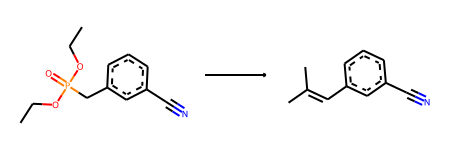

In [ ]:
rxn = "CCOP(=O)(Cc1cccc(C#N)c1)OCC>>CC(C)=Cc1cccc(C#N)c1"
test_rxn = rdChemReactions.ReactionFromSmarts(rxn, useSmiles=True)
print(filter_5(rxn))
test_rxn

all react ['CCCCCC', 'C']
prod: ['C', 'C', 'C'] all react: ['CCCCCC']
['CCCCCC'] ['C', 'C', 'C']
False


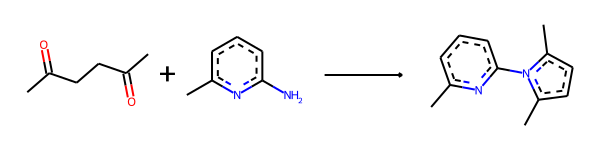

In [334]:
rxn = "COC(=O)C(Cl)SCCc1ccccc1Br>>COC(=O)C1SCCc2c(Br)cccc21"
rxn = "CC(=O)CCC(C)=O.Cc1cccc(N)n1>>Cc1cccc(-n2c(C)ccc2C)n1"
test_rxn = rdChemReactions.ReactionFromSmarts(rxn, useSmiles=True)
print(filter_4(rxn))
test_rxn